# MIT Reactor Data Set Example

**Inputs**: Control rod heights

**Outputs**: Pin power

To demonstrate pyMAISE, models are produced on an MIT reactor data set representing the institution's light-water-cooled 6MW thermal power reactor. The figure below shows the core contains 22 fuel elements, 5 locations for in-core experiments, with 6 control blades surrounding them. The data set is used to find a relationship between the 6 control blade heights and the power produced by the 22 fuel elements in the core. Therefore, the data set is constructed by perturbing the depths of the control blades in the reactor. The corresponding output results in the power levels for each of the 22 fuel elements. The data was generated using Monte Carlo simulation by the MCNP code, where the dataset size includes 1000 simulations/samples [1]. The goal is to use pyMAISE to build, tune, and compare various ML models in their performance in predicting the core power distribution based on the control blade insertion depth.

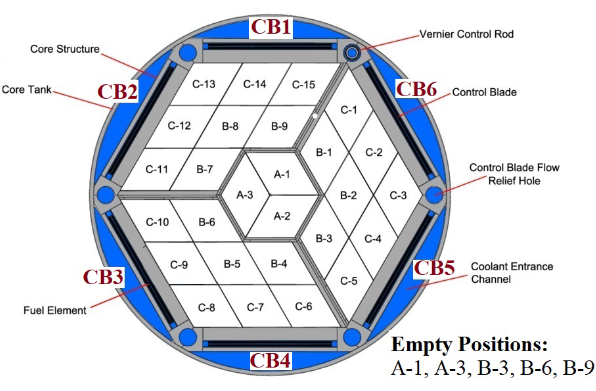

In [7]:
import pyMAISE as mai
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import ceil
import cv2
from scipy.stats import uniform, randint

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

Starting any pyMAISE job requires initialization, this includes the definition of global settings used throughout pyMAISE. These settings include:

- `verbosity`: How much pyMAISE outputs to the terminal.
- `random_state`: Some models use pseudo random algorithms during training. To create the same models every run `random_state` must be defined.
- `test_size`: Defines the fraction of the data used for model testing.
- `num_configs_saved`: Of the large number of hyper-parameter configurations run, only the top `num_configs_saved` are returned.

A dictionary of these settings are then passed to the settings class of pyMAISE.

In [2]:
settings = {
    "verbosity": 1,
    "random_state": None,
    "test_size": 0.3,
    "num_configs_saved": 5,
}
global_settings = mai.settings.init(settings_changes=settings)

## Data Loading and Pre-Processing

pyMAISE comes with several benchmarking data sets with this MIT reactor data set. Each data set has its own loading function which returns a `PreProcessor` object with the data loaded. For personal data, initialize the `PreProcessor` with the following

`preprocessor = mai.PreProcessor("path/to/data.csv", slice(0, x), slice(x, y))`

for one file with both inputs and outputs. Here `x` defines the beginning of the outputs and `y` defines the end of the outputs of the data set. For data with inputs and outputs in seperate files use the following

`preprocessor = mai.PreProcessor(["path/to/input.csv", "path/to/output.csv"])`.

In [3]:
preprocessor = mai.load_MITR()

Reading data from ['/home/myerspat/dev/pyMAISE/pyMAISE/data/crx.csv', '/home/myerspat/dev/pyMAISE/pyMAISE/data/powery.csv']


The MIT reactor data set has 6 inputs; one for each control rod position:

In [4]:
preprocessor.inputs.head()

,CR1,CR2,CR3,CR4,CR5,CR6
0,25.959917,22.949372,20.853175,24.669168,20.481047,25.357266
1,21.753868,25.360626,20.588530,20.110872,27.467110,25.816585
2,27.429199,23.570180,27.596307,26.390445,23.996037,24.611822
3,21.788159,24.289480,25.195061,23.462239,25.314196,21.665092
4,20.651764,26.309493,24.645944,25.897686,23.748592,26.946972


and 22 fuel element power outputs:

In [5]:
preprocessor.outputs.head()

,A-2,B-1,B-2,B-4,B-5,B-7,B-8,C-1,C-2,C-3,...,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13,C-14,C-15
0,25930.916138,22958.314941,21725.516357,22799.333618,21815.979675,22785.586487,21279.806152,18421.966827,18484.818298,18886.733154,...,18784.499451,18171.291687,18604.801849,18593.999756,19458.648743,18113.577637,17390.992249,17912.014526,18207.042603,19089.969421
1,25883.078125,22856.061951,21602.108765,22721.063293,21698.868164,22916.184875,21447.282837,17945.424408,17894.501221,18588.017639,...,18727.330261,18035.394409,18114.253510,18005.816956,19148.114197,18807.224915,18331.525757,18699.555573,18381.290527,19052.587830
2,25672.208252,22584.910950,21419.950256,22721.304749,21802.134827,22572.159546,20975.878662,18184.984711,18316.332275,18761.267548,...,19440.091980,18987.642334,19354.132843,18791.702271,19605.605347,18351.250732,17572.990784,17878.914185,17831.210449,18702.889954
3,25897.859375,22661.180420,21529.638977,22943.255249,21972.662415,22834.193054,21179.314453,17646.767395,17705.476135,18429.696381,...,19395.144714,18863.283508,19052.659454,18591.373230,19532.076660,18663.584961,17934.262787,17923.863403,17608.497009,18401.561340
4,25761.079712,22576.364319,21405.163879,22783.927185,21851.152466,22721.955627,21140.955383,17564.821411,17507.742371,18373.703308,...,19245.952881,18686.140686,19088.561737,18763.566223,19647.963135,18462.088745,17718.471191,18201.529053,18189.525635,18834.598328


To get a better understanding of this data set lets plot a correlation matrix of the data.

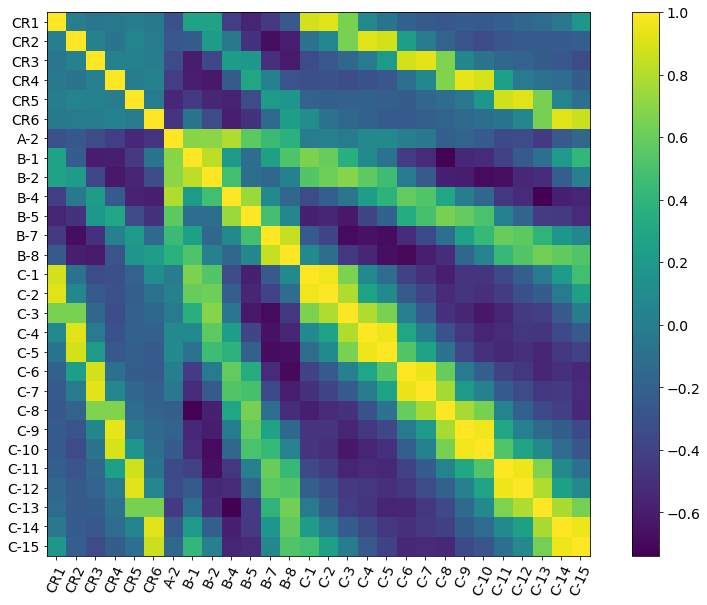

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax)

With the data loaded it can now be pre-processed by min-max, standard, or no scaling through the following functions:

- `preprocessor.min_max_scale()`: Scale based on the minimum and maximum data points in a feature.
- `preprocessor.std_scale()`: Standard scale the data.
- `preprocessor.data_split()`: No scaling.

All three return a tuple of training and testing data, `(xtrain, xtest, ytrain, ytest)`. Both `min_max_scale()` and `std_scale()` can scale input and/or output data depending on how `scale_x` and `scale_y` are defined. To min-max scale only the inputs run `preprocessor.min_max_scale(scale_y=False)`. For the MIT reactor data set both inputs and outputs are min-max scaled.

In [9]:
data = preprocessor.min_max_scale()

MinMax scaling data


## Model Initialization

pyMAISE supports both classical ML methods and dense sequential neural networks. Here is a list of all the models supported and their corresponding names in pyMAISE:

- Linear Regression (LR): `linear`
- Lasso Regression (LS): `lasso`
- Support Vector Regression (SVR): `svr`
    - Only works for 1D outputs; therefore, it is not explored in this data set.
- Decision Tree Regression (DTR): `dtree`
- Random Forest Regression (RFR): `rforest`
- K-nearest Neighbors Regression (KNN): `knn`
- Neural Networks (NN): `nn`

Prior to hyper-parameter tuning all models under investigation must be initialized. To define the models of interest list their names in the `models` list. Then define a dicitonary within the `model_settings` dictionary with the initial guess (if you plan to use random or Bayesian search) and defaults for each model. Not all model settings must be defined as their defaults match the original scikit-learn or keras settings. If the defaults satisfy your initial guess then a dictionary of settings is not necessary. Use the MIT reactor data set model settings as a reference:

In [10]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 4,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": "mean_absolute_error",
        "batch_size": 8,
        "epochs": 50,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": 6,
        # Middle Layers
        "mid_num_node_strategy": "linear",  # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": 22,
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 5e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

## Hyper-parameter Tuning

Three hyper-parameter tuning functions are supported: grid, random, and Bayesian search. Using lists or Numpy arrays, a grid of hyper-parameter configurations of interest can be used in grid and Bayesian search. While the Bayesian search function takes in the same dictionary as grid search, the function only uses the minimum and maximum value of the array in the case of numbers. For random search the parameter distributions can also be defined as Numpy arrays or lists; however, Scipy distributions can also be used to define different sampling distributions for continuous functions. For the MIT reactor data set a random search strategy is used for the classical methods and a Bayesian search is used for the neural networks. 

In [11]:
random_search_dist = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 2 - 20
        "max_features": [None, 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=3, high=20), # 3 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=5, high=30), # 5 - 30
        "p": randint(low=2, high=10), # 2 - 10
    },
}
bayesian_search_limits = {
    "nn": {
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 6],
        "start_num_nodes": [50, 200],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_distributions=random_search_dist, 
    models=["linear"] + list(random_search_dist.keys()), 
    n_iter=100, 
    cv=2,
)
bayesian_search_configs = tuning.bayesian_search(
    search_spaces=bayesian_search_limits,
    models=bayesian_search_limits.keys(),
    n_iter=50,
    cv=2
)
stop = time.time()

Hyper-parameter tuning with random search
Hyper-parameter tuning search space was not provided for linear, doing manual fit
-- linear
-- lasso
Fitting 2 folds for each of 100 candidates, totalling 200 fits
-- dtree
Fitting 2 folds for each of 100 candidates, totalling 200 fits
-- rforest
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 182 out of 182 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 152 out of 152 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

-- knn
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Hyper-parameter tuning with bayesian search
-- nn


2023-02-21 20:43:45.962262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-21 20:43:45.962837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/myerspat/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-21 20:43:45.962948: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/myerspat/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-21 20:43:45.963017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
6/6 [==============================] - 1s 49ms/step - loss: 0.4940 - mean_absolute_error: 0.4940 - val_loss: 0.4928 - val_mean_absolute_error: 0.4928
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4914 - mean_absolute_error: 0.4914 - val_loss: 0.4901 - val_mean_absolute_error: 0.4901
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.4886 - mean_absolute_error: 0.4886 - val_loss: 0.4871 - val_mean_absolute_error: 0.4871
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4854 - mean_absolute_error: 0.4854 - val_loss: 0.4837 - val_mean_absolute_error: 0.4837
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4817 - mean_absolute_error: 0.4817 - val_loss: 0.4794 - val_mean_absolute_error: 0.4794
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4770 - mean_absolute_error: 0.4770 - val_loss: 0.4740 - val_mean

6/6 [==============================] - 1s 42ms/step - loss: 0.4937 - mean_absolute_error: 0.4937 - val_loss: 0.4937 - val_mean_absolute_error: 0.4937
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4912 - mean_absolute_error: 0.4912 - val_loss: 0.4912 - val_mean_absolute_error: 0.4912
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4886 - mean_absolute_error: 0.4886 - val_loss: 0.4884 - val_mean_absolute_error: 0.4884
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4856 - mean_absolute_error: 0.4856 - val_loss: 0.4853 - val_mean_absolute_error: 0.4853
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4824 - mean_absolute_error: 0.4824 - val_loss: 0.4818 - val_mean_absolute_error: 0.4818
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 0.4786 - mean_absolute_error: 0.4786 - val_loss: 0.4776 - val_mean_absolute_error: 0.4776
Epoch 7/50
6/6 [==============================

22/22 [==============================] - 1s 12ms/step - loss: 0.4739 - mean_absolute_error: 0.4739 - val_loss: 0.3958 - val_mean_absolute_error: 0.3958
Epoch 2/50
22/22 [==============================] - 0s 6ms/step - loss: 0.2462 - mean_absolute_error: 0.2462 - val_loss: 0.1737 - val_mean_absolute_error: 0.1737
Epoch 3/50
22/22 [==============================] - 0s 6ms/step - loss: 0.1851 - mean_absolute_error: 0.1851 - val_loss: 0.1682 - val_mean_absolute_error: 0.1682
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1813 - mean_absolute_error: 0.1813 - val_loss: 0.1667 - val_mean_absolute_error: 0.1667
Epoch 5/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1778 - mean_absolute_error: 0.1778 - val_loss: 0.1644 - val_mean_absolute_error: 0.1644
Epoch 6/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1632 - val_mean_absolute_error: 0.1632
Epoch 7/50
22/22 [====================

22/22 [==============================] - 1s 11ms/step - loss: 0.4748 - mean_absolute_error: 0.4748 - val_loss: 0.4027 - val_mean_absolute_error: 0.4027
Epoch 2/50
22/22 [==============================] - 0s 5ms/step - loss: 0.2694 - mean_absolute_error: 0.2694 - val_loss: 0.2110 - val_mean_absolute_error: 0.2110
Epoch 3/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1937 - mean_absolute_error: 0.1937 - val_loss: 0.1869 - val_mean_absolute_error: 0.1869
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1843 - mean_absolute_error: 0.1843 - val_loss: 0.1845 - val_mean_absolute_error: 0.1845
Epoch 5/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1798 - mean_absolute_error: 0.1798 - val_loss: 0.1837 - val_mean_absolute_error: 0.1837
Epoch 6/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1782 - mean_absolute_error: 0.1782 - val_loss: 0.1806 - val_mean_absolute_error: 0.1806
Epoch 7/50
22/22 [====================

Epoch 1/50
5/5 [==============================] - 1s 43ms/step - loss: 0.4960 - mean_absolute_error: 0.4960 - val_loss: 0.4931 - val_mean_absolute_error: 0.4931
Epoch 2/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4913 - mean_absolute_error: 0.4913 - val_loss: 0.4880 - val_mean_absolute_error: 0.4880
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4853 - mean_absolute_error: 0.4853 - val_loss: 0.4827 - val_mean_absolute_error: 0.4827
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4805 - mean_absolute_error: 0.4805 - val_loss: 0.4772 - val_mean_absolute_error: 0.4772
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4746 - mean_absolute_error: 0.4746 - val_loss: 0.4712 - val_mean_absolute_error: 0.4712
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4688 - mean_absolute_error: 0.4688 - val_loss: 0.4649 - val_mean_absolute_error: 0.4649
Epoch 7/50
5/5 [==================

5/5 [==============================] - 1s 40ms/step - loss: 0.4956 - mean_absolute_error: 0.4956 - val_loss: 0.4936 - val_mean_absolute_error: 0.4936
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4896 - mean_absolute_error: 0.4896 - val_loss: 0.4877 - val_mean_absolute_error: 0.4877
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4837 - mean_absolute_error: 0.4837 - val_loss: 0.4816 - val_mean_absolute_error: 0.4816
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4781 - mean_absolute_error: 0.4781 - val_loss: 0.4752 - val_mean_absolute_error: 0.4752
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4716 - mean_absolute_error: 0.4716 - val_loss: 0.4685 - val_mean_absolute_error: 0.4685
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4643 - mean_absolute_error: 0.4643 - val_loss: 0.4612 - val_mean_absolute_error: 0.4612
Epoch 7/50
5/5 [=============================

9/9 [==============================] - 1s 24ms/step - loss: 0.4903 - mean_absolute_error: 0.4903 - val_loss: 0.4829 - val_mean_absolute_error: 0.4829
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 0.4733 - mean_absolute_error: 0.4733 - val_loss: 0.4553 - val_mean_absolute_error: 0.4553
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4240 - mean_absolute_error: 0.4240 - val_loss: 0.3598 - val_mean_absolute_error: 0.3598
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2798 - mean_absolute_error: 0.2798 - val_loss: 0.1971 - val_mean_absolute_error: 0.1971
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2123 - mean_absolute_error: 0.2123 - val_loss: 0.1737 - val_mean_absolute_error: 0.1737
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1861 - mean_absolute_error: 0.1861 - val_loss: 0.1712 - val_mean_absolute_error: 0.1712
Epoch 7/50
9/9 [==============================] -

Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4699 - mean_absolute_error: 0.4699 - val_loss: 0.4507 - val_mean_absolute_error: 0.4507
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4158 - mean_absolute_error: 0.4158 - val_loss: 0.3476 - val_mean_absolute_error: 0.3476
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2696 - mean_absolute_error: 0.2696 - val_loss: 0.2170 - val_mean_absolute_error: 0.2170
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2238 - mean_absolute_error: 0.2238 - val_loss: 0.1935 - val_mean_absolute_error: 0.1935
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1960 - mean_absolute_error: 0.1960 - val_loss: 0.1968 - val_mean_absolute_error: 0.1968
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1875 - mean_absolute_error: 0.1875 - val_loss: 0.1892 - val_mean_absolute_error: 0.1892
Epoch 8/50
9/9 [========================

12/12 [==============================] - 0s 7ms/step - loss: 0.4861 - mean_absolute_error: 0.4861 - val_loss: 0.4820 - val_mean_absolute_error: 0.4820
Epoch 3/50
12/12 [==============================] - 0s 7ms/step - loss: 0.4764 - mean_absolute_error: 0.4764 - val_loss: 0.4689 - val_mean_absolute_error: 0.4689
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.4578 - mean_absolute_error: 0.4578 - val_loss: 0.4422 - val_mean_absolute_error: 0.4422
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.4192 - mean_absolute_error: 0.4192 - val_loss: 0.3849 - val_mean_absolute_error: 0.3849
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 0.3420 - mean_absolute_error: 0.3420 - val_loss: 0.2796 - val_mean_absolute_error: 0.2796
Epoch 7/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2386 - mean_absolute_error: 0.2386 - val_loss: 0.1909 - val_mean_absolute_error: 0.1909
Epoch 8/50
12/12 [=====================

12/12 [==============================] - 0s 6ms/step - loss: 0.4847 - mean_absolute_error: 0.4847 - val_loss: 0.4811 - val_mean_absolute_error: 0.4811
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.4735 - mean_absolute_error: 0.4735 - val_loss: 0.4655 - val_mean_absolute_error: 0.4655
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.4520 - mean_absolute_error: 0.4520 - val_loss: 0.4345 - val_mean_absolute_error: 0.4345
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.4105 - mean_absolute_error: 0.4105 - val_loss: 0.3722 - val_mean_absolute_error: 0.3722
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.3302 - mean_absolute_error: 0.3302 - val_loss: 0.2736 - val_mean_absolute_error: 0.2736
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 0.2363 - mean_absolute_error: 0.2363 - val_loss: 0.2118 - val_mean_absolute_error: 0.2118
Epoch 8/50
12/12 [=====================

Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4886 - mean_absolute_error: 0.4886 - val_loss: 0.4857 - val_mean_absolute_error: 0.4857
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4830 - mean_absolute_error: 0.4830 - val_loss: 0.4790 - val_mean_absolute_error: 0.4790
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4748 - mean_absolute_error: 0.4748 - val_loss: 0.4677 - val_mean_absolute_error: 0.4677
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4590 - mean_absolute_error: 0.4590 - val_loss: 0.4417 - val_mean_absolute_error: 0.4417
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.4181 - mean_absolute_error: 0.4181 - val_loss: 0.3677 - val_mean_absolute_error: 0.3677
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.3116 - mean_absolute_error: 0.3116 - val_loss: 0.2187 - val_mean_absolute_error: 0.2187
Epoch 8/50
8/8 [========================

8/8 [==============================] - 0s 8ms/step - loss: 0.4890 - mean_absolute_error: 0.4890 - val_loss: 0.4879 - val_mean_absolute_error: 0.4879
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4844 - mean_absolute_error: 0.4844 - val_loss: 0.4828 - val_mean_absolute_error: 0.4828
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4787 - mean_absolute_error: 0.4787 - val_loss: 0.4759 - val_mean_absolute_error: 0.4759
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4701 - mean_absolute_error: 0.4701 - val_loss: 0.4633 - val_mean_absolute_error: 0.4633
Epoch 6/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4518 - mean_absolute_error: 0.4518 - val_loss: 0.4326 - val_mean_absolute_error: 0.4326
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.4034 - mean_absolute_error: 0.4034 - val_loss: 0.3468 - val_mean_absolute_error: 0.3468
Epoch 8/50
8/8 [==============================] - 0

5/5 [==============================] - 0s 12ms/step - loss: 0.4889 - mean_absolute_error: 0.4889 - val_loss: 0.4863 - val_mean_absolute_error: 0.4863
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4837 - mean_absolute_error: 0.4837 - val_loss: 0.4806 - val_mean_absolute_error: 0.4806
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4775 - mean_absolute_error: 0.4775 - val_loss: 0.4733 - val_mean_absolute_error: 0.4733
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4691 - mean_absolute_error: 0.4691 - val_loss: 0.4630 - val_mean_absolute_error: 0.4630
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4566 - mean_absolute_error: 0.4566 - val_loss: 0.4469 - val_mean_absolute_error: 0.4469
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4363 - mean_absolute_error: 0.4363 - val_loss: 0.4203 - val_mean_absolute_error: 0.4203
Epoch 8/50
5/5 [=============================

5/5 [==============================] - 0s 12ms/step - loss: 0.4884 - mean_absolute_error: 0.4884 - val_loss: 0.4868 - val_mean_absolute_error: 0.4868
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4829 - mean_absolute_error: 0.4829 - val_loss: 0.4806 - val_mean_absolute_error: 0.4806
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4758 - mean_absolute_error: 0.4758 - val_loss: 0.4722 - val_mean_absolute_error: 0.4722
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4660 - mean_absolute_error: 0.4660 - val_loss: 0.4600 - val_mean_absolute_error: 0.4600
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4514 - mean_absolute_error: 0.4514 - val_loss: 0.4410 - val_mean_absolute_error: 0.4410
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4280 - mean_absolute_error: 0.4280 - val_loss: 0.4099 - val_mean_absolute_error: 0.4099
Epoch 8/50
5/5 [=============================

6/6 [==============================] - 0s 9ms/step - loss: 0.4936 - mean_absolute_error: 0.4936 - val_loss: 0.4933 - val_mean_absolute_error: 0.4933
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4926 - mean_absolute_error: 0.4926 - val_loss: 0.4923 - val_mean_absolute_error: 0.4923
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4915 - mean_absolute_error: 0.4915 - val_loss: 0.4912 - val_mean_absolute_error: 0.4912
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4904 - mean_absolute_error: 0.4904 - val_loss: 0.4900 - val_mean_absolute_error: 0.4900
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4891 - mean_absolute_error: 0.4891 - val_loss: 0.4887 - val_mean_absolute_error: 0.4887
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4877 - mean_absolute_error: 0.4877 - val_loss: 0.4872 - val_mean_absolute_error: 0.4872
Epoch 8/50
6/6 [==============================] - 

6/6 [==============================] - 0s 10ms/step - loss: 0.4932 - mean_absolute_error: 0.4932 - val_loss: 0.4941 - val_mean_absolute_error: 0.4941
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4921 - mean_absolute_error: 0.4921 - val_loss: 0.4930 - val_mean_absolute_error: 0.4930
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4909 - mean_absolute_error: 0.4909 - val_loss: 0.4917 - val_mean_absolute_error: 0.4917
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.4896 - mean_absolute_error: 0.4896 - val_loss: 0.4903 - val_mean_absolute_error: 0.4903
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4881 - mean_absolute_error: 0.4881 - val_loss: 0.4887 - val_mean_absolute_error: 0.4887
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.4863 - mean_absolute_error: 0.4863 - val_loss: 0.4868 - val_mean_absolute_error: 0.4868
Epoch 8/50
6/6 [==============================]

13/13 [==============================] - 0s 6ms/step - loss: 0.4722 - mean_absolute_error: 0.4722 - val_loss: 0.4545 - val_mean_absolute_error: 0.4545
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4229 - mean_absolute_error: 0.4229 - val_loss: 0.3680 - val_mean_absolute_error: 0.3680
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2970 - mean_absolute_error: 0.2970 - val_loss: 0.2127 - val_mean_absolute_error: 0.2127
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.2167 - mean_absolute_error: 0.2167 - val_loss: 0.1847 - val_mean_absolute_error: 0.1847
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1900 - mean_absolute_error: 0.1900 - val_loss: 0.1751 - val_mean_absolute_error: 0.1751
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1833 - mean_absolute_error: 0.1833 - val_loss: 0.1700 - val_mean_absolute_error: 0.1700
Epoch 8/50
13/13 [=====================

13/13 [==============================] - 0s 6ms/step - loss: 0.4734 - mean_absolute_error: 0.4734 - val_loss: 0.4587 - val_mean_absolute_error: 0.4587
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4303 - mean_absolute_error: 0.4303 - val_loss: 0.3824 - val_mean_absolute_error: 0.3824
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.3150 - mean_absolute_error: 0.3150 - val_loss: 0.2316 - val_mean_absolute_error: 0.2316
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.2192 - mean_absolute_error: 0.2192 - val_loss: 0.2078 - val_mean_absolute_error: 0.2078
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1936 - mean_absolute_error: 0.1936 - val_loss: 0.1948 - val_mean_absolute_error: 0.1948
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.1881 - mean_absolute_error: 0.1881 - val_loss: 0.1893 - val_mean_absolute_error: 0.1893
Epoch 8/50
13/13 [=====================

Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3056 - mean_absolute_error: 0.3056 - val_loss: 0.1998 - val_mean_absolute_error: 0.1998
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1923 - mean_absolute_error: 0.1923 - val_loss: 0.1724 - val_mean_absolute_error: 0.1724
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1841 - mean_absolute_error: 0.1841 - val_loss: 0.1712 - val_mean_absolute_error: 0.1712
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1800 - mean_absolute_error: 0.1800 - val_loss: 0.1691 - val_mean_absolute_error: 0.1691
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1803 - mean_absolute_error: 0.1803 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1773 - mean_absolute_error: 0.1773 - val_loss: 0.1644 - val_mean_absolute_error: 0.1644
Epoch 8/50
27/27 [==========

Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3355 - mean_absolute_error: 0.3355 - val_loss: 0.2215 - val_mean_absolute_error: 0.2215
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.2007 - mean_absolute_error: 0.2007 - val_loss: 0.1919 - val_mean_absolute_error: 0.1919
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1880 - mean_absolute_error: 0.1880 - val_loss: 0.1887 - val_mean_absolute_error: 0.1887
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1842 - mean_absolute_error: 0.1842 - val_loss: 0.1867 - val_mean_absolute_error: 0.1867
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1819 - mean_absolute_error: 0.1819 - val_loss: 0.1858 - val_mean_absolute_error: 0.1858
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1815 - mean_absolute_error: 0.1815 - val_loss: 0.1831 - val_mean_absolute_error: 0.1831
Epoch 8/50
27/27 [==========

38/38 [==============================] - 1s 6ms/step - loss: 0.3475 - mean_absolute_error: 0.3475 - val_loss: 0.1785 - val_mean_absolute_error: 0.1785
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1932 - mean_absolute_error: 0.1932 - val_loss: 0.1642 - val_mean_absolute_error: 0.1642
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1801 - mean_absolute_error: 0.1801 - val_loss: 0.1520 - val_mean_absolute_error: 0.1520
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1618 - mean_absolute_error: 0.1618 - val_loss: 0.1369 - val_mean_absolute_error: 0.1369
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1473 - mean_absolute_error: 0.1473 - val_loss: 0.1154 - val_mean_absolute_error: 0.1154
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1299 - mean_absolute_error: 0.1299 - val_loss: 0.1010 - val_mean_absolute_error: 0.1010
Epoch 7/50
38/38 [=====================

38/38 [==============================] - 1s 6ms/step - loss: 0.3509 - mean_absolute_error: 0.3509 - val_loss: 0.1935 - val_mean_absolute_error: 0.1935
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1968 - mean_absolute_error: 0.1968 - val_loss: 0.1808 - val_mean_absolute_error: 0.1808
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1813 - mean_absolute_error: 0.1813 - val_loss: 0.1649 - val_mean_absolute_error: 0.1649
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1674 - mean_absolute_error: 0.1674 - val_loss: 0.1472 - val_mean_absolute_error: 0.1472
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1505 - mean_absolute_error: 0.1505 - val_loss: 0.1259 - val_mean_absolute_error: 0.1259
Epoch 6/50
38/38 [==============================] - 0s 3ms/step - loss: 0.1304 - mean_absolute_error: 0.1304 - val_loss: 0.1071 - val_mean_absolute_error: 0.1071
Epoch 7/50
38/38 [=====================

38/38 [==============================] - 1s 6ms/step - loss: 0.3216 - mean_absolute_error: 0.3216 - val_loss: 0.1761 - val_mean_absolute_error: 0.1761
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1891 - mean_absolute_error: 0.1891 - val_loss: 0.1547 - val_mean_absolute_error: 0.1547
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1636 - mean_absolute_error: 0.1636 - val_loss: 0.1293 - val_mean_absolute_error: 0.1293
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1378 - mean_absolute_error: 0.1378 - val_loss: 0.1037 - val_mean_absolute_error: 0.1037
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1162 - mean_absolute_error: 0.1162 - val_loss: 0.0798 - val_mean_absolute_error: 0.0798
Epoch 6/50
38/38 [==============================] - 0s 3ms/step - loss: 0.1007 - mean_absolute_error: 0.1007 - val_loss: 0.0653 - val_mean_absolute_error: 0.0653
Epoch 7/50
38/38 [=====================

38/38 [==============================] - 1s 7ms/step - loss: 0.3294 - mean_absolute_error: 0.3294 - val_loss: 0.1956 - val_mean_absolute_error: 0.1956
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1886 - mean_absolute_error: 0.1886 - val_loss: 0.1697 - val_mean_absolute_error: 0.1697
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1658 - mean_absolute_error: 0.1658 - val_loss: 0.1434 - val_mean_absolute_error: 0.1434
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1404 - mean_absolute_error: 0.1404 - val_loss: 0.1132 - val_mean_absolute_error: 0.1132
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1187 - mean_absolute_error: 0.1187 - val_loss: 0.0859 - val_mean_absolute_error: 0.0859
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1033 - mean_absolute_error: 0.1033 - val_loss: 0.0698 - val_mean_absolute_error: 0.0698
Epoch 7/50
38/38 [=====================

9/9 [==============================] - 1s 47ms/step - loss: 0.4878 - mean_absolute_error: 0.4878 - val_loss: 0.4874 - val_mean_absolute_error: 0.4874
Epoch 2/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4865 - mean_absolute_error: 0.4865 - val_loss: 0.4866 - val_mean_absolute_error: 0.4866
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4856 - mean_absolute_error: 0.4856 - val_loss: 0.4858 - val_mean_absolute_error: 0.4858
Epoch 4/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4854 - mean_absolute_error: 0.4854 - val_loss: 0.4850 - val_mean_absolute_error: 0.4850
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4840 - mean_absolute_error: 0.4840 - val_loss: 0.4842 - val_mean_absolute_error: 0.4842
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4835 - mean_absolute_error: 0.4835 - val_loss: 0.4834 - val_mean_absolute_error: 0.4834
Epoch 7/50
9/9 [==============================] - 

Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4968 - mean_absolute_error: 0.4968 - val_loss: 0.4975 - val_mean_absolute_error: 0.4975
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4955 - mean_absolute_error: 0.4955 - val_loss: 0.4967 - val_mean_absolute_error: 0.4967
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4950 - mean_absolute_error: 0.4950 - val_loss: 0.4959 - val_mean_absolute_error: 0.4959
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4932 - mean_absolute_error: 0.4932 - val_loss: 0.4950 - val_mean_absolute_error: 0.4950
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4925 - mean_absolute_error: 0.4925 - val_loss: 0.4942 - val_mean_absolute_error: 0.4942
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.4925 - mean_absolute_error: 0.4925 - val_loss: 0.4934 - val_mean_absolute_error: 0.4934
Epoch 8/50
9/9 [========================

38/38 [==============================] - 0s 4ms/step - loss: 0.2115 - mean_absolute_error: 0.2115 - val_loss: 0.1661 - val_mean_absolute_error: 0.1661
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1845 - mean_absolute_error: 0.1845 - val_loss: 0.1580 - val_mean_absolute_error: 0.1580
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1721 - mean_absolute_error: 0.1721 - val_loss: 0.1460 - val_mean_absolute_error: 0.1460
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1621 - mean_absolute_error: 0.1621 - val_loss: 0.1336 - val_mean_absolute_error: 0.1336
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1473 - mean_absolute_error: 0.1473 - val_loss: 0.1213 - val_mean_absolute_error: 0.1213
Epoch 7/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1380 - mean_absolute_error: 0.1380 - val_loss: 0.1068 - val_mean_absolute_error: 0.1068
Epoch 8/50
38/38 [=====================

38/38 [==============================] - 0s 4ms/step - loss: 0.2221 - mean_absolute_error: 0.2221 - val_loss: 0.1890 - val_mean_absolute_error: 0.1890
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1920 - mean_absolute_error: 0.1920 - val_loss: 0.1787 - val_mean_absolute_error: 0.1787
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1822 - mean_absolute_error: 0.1822 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1689 - mean_absolute_error: 0.1689 - val_loss: 0.1545 - val_mean_absolute_error: 0.1545
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1602 - mean_absolute_error: 0.1602 - val_loss: 0.1418 - val_mean_absolute_error: 0.1418
Epoch 7/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1454 - mean_absolute_error: 0.1454 - val_loss: 0.1264 - val_mean_absolute_error: 0.1264
Epoch 8/50
38/38 [=====================

Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 0.2001 - mean_absolute_error: 0.2001 - val_loss: 0.1721 - val_mean_absolute_error: 0.1721
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1819 - mean_absolute_error: 0.1819 - val_loss: 0.1674 - val_mean_absolute_error: 0.1674
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1779 - mean_absolute_error: 0.1779 - val_loss: 0.1639 - val_mean_absolute_error: 0.1639
Epoch 5/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1749 - mean_absolute_error: 0.1749 - val_loss: 0.1605 - val_mean_absolute_error: 0.1605
Epoch 6/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1720 - mean_absolute_error: 0.1720 - val_loss: 0.1595 - val_mean_absolute_error: 0.1595
Epoch 7/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1674 - mean_absolute_error: 0.1674 - val_loss: 0.1513 - val_mean_absolute_error: 0.1513
Epoch 8/50
33/33 [==========

Epoch 2/50
33/33 [==============================] - 0s 4ms/step - loss: 0.2022 - mean_absolute_error: 0.2022 - val_loss: 0.1909 - val_mean_absolute_error: 0.1909
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1843 - mean_absolute_error: 0.1843 - val_loss: 0.1870 - val_mean_absolute_error: 0.1870
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1810 - mean_absolute_error: 0.1810 - val_loss: 0.1819 - val_mean_absolute_error: 0.1819
Epoch 5/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1774 - mean_absolute_error: 0.1774 - val_loss: 0.1779 - val_mean_absolute_error: 0.1779
Epoch 6/50
33/33 [==============================] - 0s 4ms/step - loss: 0.1718 - mean_absolute_error: 0.1718 - val_loss: 0.1707 - val_mean_absolute_error: 0.1707
Epoch 7/50
33/33 [==============================] - 0s 5ms/step - loss: 0.1634 - mean_absolute_error: 0.1634 - val_loss: 0.1551 - val_mean_absolute_error: 0.1551
Epoch 8/50
33/33 [==========

5/5 [==============================] - 1s 45ms/step - loss: 0.4763 - mean_absolute_error: 0.4763 - val_loss: 0.4457 - val_mean_absolute_error: 0.4457
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4256 - mean_absolute_error: 0.4256 - val_loss: 0.3896 - val_mean_absolute_error: 0.3896
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.3636 - mean_absolute_error: 0.3636 - val_loss: 0.3182 - val_mean_absolute_error: 0.3182
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2911 - mean_absolute_error: 0.2911 - val_loss: 0.2376 - val_mean_absolute_error: 0.2376
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.2253 - mean_absolute_error: 0.2253 - val_loss: 0.1825 - val_mean_absolute_error: 0.1825
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1973 - mean_absolute_error: 0.1973 - val_loss: 0.1787 - val_mean_absolute_error: 0.1787
Epoch 7/50
5/5 [=============================

5/5 [==============================] - 1s 39ms/step - loss: 0.4676 - mean_absolute_error: 0.4676 - val_loss: 0.4364 - val_mean_absolute_error: 0.4364
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4148 - mean_absolute_error: 0.4148 - val_loss: 0.3783 - val_mean_absolute_error: 0.3783
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 0.3522 - mean_absolute_error: 0.3522 - val_loss: 0.3096 - val_mean_absolute_error: 0.3096
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2841 - mean_absolute_error: 0.2841 - val_loss: 0.2391 - val_mean_absolute_error: 0.2391
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2276 - mean_absolute_error: 0.2276 - val_loss: 0.2004 - val_mean_absolute_error: 0.2004
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2016 - mean_absolute_error: 0.2016 - val_loss: 0.1977 - val_mean_absolute_error: 0.1977
Epoch 7/50
5/5 [=============================

5/5 [==============================] - 1s 46ms/step - loss: 0.4939 - mean_absolute_error: 0.4939 - val_loss: 0.4923 - val_mean_absolute_error: 0.4923
Epoch 2/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4908 - mean_absolute_error: 0.4908 - val_loss: 0.4889 - val_mean_absolute_error: 0.4889
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4870 - mean_absolute_error: 0.4870 - val_loss: 0.4845 - val_mean_absolute_error: 0.4845
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4818 - mean_absolute_error: 0.4818 - val_loss: 0.4777 - val_mean_absolute_error: 0.4777
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4731 - mean_absolute_error: 0.4731 - val_loss: 0.4647 - val_mean_absolute_error: 0.4647
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4550 - mean_absolute_error: 0.4550 - val_loss: 0.4361 - val_mean_absolute_error: 0.4361
Epoch 7/50
5/5 [=============================

5/5 [==============================] - 1s 50ms/step - loss: 0.4936 - mean_absolute_error: 0.4936 - val_loss: 0.4934 - val_mean_absolute_error: 0.4934
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4907 - mean_absolute_error: 0.4907 - val_loss: 0.4903 - val_mean_absolute_error: 0.4903
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.4874 - mean_absolute_error: 0.4874 - val_loss: 0.4865 - val_mean_absolute_error: 0.4865
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4831 - mean_absolute_error: 0.4831 - val_loss: 0.4812 - val_mean_absolute_error: 0.4812
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4763 - mean_absolute_error: 0.4763 - val_loss: 0.4716 - val_mean_absolute_error: 0.4716
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4633 - mean_absolute_error: 0.4633 - val_loss: 0.4507 - val_mean_absolute_error: 0.4507
Epoch 7/50
5/5 [=============================

38/38 [==============================] - 1s 8ms/step - loss: 0.3934 - mean_absolute_error: 0.3934 - val_loss: 0.2024 - val_mean_absolute_error: 0.2024
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1884 - mean_absolute_error: 0.1884 - val_loss: 0.1729 - val_mean_absolute_error: 0.1729
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1822 - mean_absolute_error: 0.1822 - val_loss: 0.1657 - val_mean_absolute_error: 0.1657
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1768 - mean_absolute_error: 0.1768 - val_loss: 0.1628 - val_mean_absolute_error: 0.1628
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1750 - mean_absolute_error: 0.1750 - val_loss: 0.1599 - val_mean_absolute_error: 0.1599
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1726 - mean_absolute_error: 0.1726 - val_loss: 0.1592 - val_mean_absolute_error: 0.1592
Epoch 7/50
38/38 [=====================

38/38 [==============================] - 1s 7ms/step - loss: 0.3734 - mean_absolute_error: 0.3734 - val_loss: 0.1985 - val_mean_absolute_error: 0.1985
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1899 - mean_absolute_error: 0.1899 - val_loss: 0.1870 - val_mean_absolute_error: 0.1870
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1825 - mean_absolute_error: 0.1825 - val_loss: 0.1835 - val_mean_absolute_error: 0.1835
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1792 - mean_absolute_error: 0.1792 - val_loss: 0.1806 - val_mean_absolute_error: 0.1806
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1792 - val_mean_absolute_error: 0.1792
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1743 - mean_absolute_error: 0.1743 - val_loss: 0.1775 - val_mean_absolute_error: 0.1775
Epoch 7/50
38/38 [=====================

Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.4835 - mean_absolute_error: 0.4835 - val_loss: 0.4675 - val_mean_absolute_error: 0.4675
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.3974 - mean_absolute_error: 0.3974 - val_loss: 0.1969 - val_mean_absolute_error: 0.1969
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1889 - mean_absolute_error: 0.1889 - val_loss: 0.1657 - val_mean_absolute_error: 0.1657
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1787 - mean_absolute_error: 0.1787 - val_loss: 0.1648 - val_mean_absolute_error: 0.1648
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1759 - mean_absolute_error: 0.1759 - val_loss: 0.1623 - val_mean_absolute_error: 0.1623
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1749 - mean_absolute_error: 0.1749 - val_loss: 0.1615 - val_mean_absolute_error: 0.1615
Epoch 7/50
38/38 [==========

Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.4844 - mean_absolute_error: 0.4844 - val_loss: 0.4725 - val_mean_absolute_error: 0.4725
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.4326 - mean_absolute_error: 0.4326 - val_loss: 0.3116 - val_mean_absolute_error: 0.3116
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2098 - mean_absolute_error: 0.2098 - val_loss: 0.1854 - val_mean_absolute_error: 0.1854
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1823 - mean_absolute_error: 0.1823 - val_loss: 0.1832 - val_mean_absolute_error: 0.1832
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1823 - mean_absolute_error: 0.1823 - val_loss: 0.1827 - val_mean_absolute_error: 0.1827
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1799 - mean_absolute_error: 0.1799 - val_loss: 0.1816 - val_mean_absolute_error: 0.1816
Epoch 7/50
38/38 [==========

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.4009 - mean_absolute_error: 0.4009 - val_loss: 0.2073 - val_mean_absolute_error: 0.2073
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1938 - mean_absolute_error: 0.1938 - val_loss: 0.1696 - val_mean_absolute_error: 0.1696
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1791 - mean_absolute_error: 0.1791 - val_loss: 0.1669 - val_mean_absolute_error: 0.1669
Epoch 4/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1751 - mean_absolute_error: 0.1751 - val_loss: 0.1629 - val_mean_absolute_error: 0.1629
Epoch 5/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1615 - val_mean_absolute_error: 0.1615
Epoch 6/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1725 - mean_absolute_error: 0.1725 - val_loss: 0.1611 - v

44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.3881 - mean_absolute_error: 0.3881 - val_loss: 0.2169 - val_mean_absolute_error: 0.2169
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1933 - mean_absolute_error: 0.1933 - val_loss: 0.1867 - val_mean_absolute_error: 0.1867
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1815 - mean_absolute_error: 0.1815 - val_loss: 0.1817 - val_mean_absolute_error: 0.1817
Epoch 4/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1780 - mean_absolute_error: 0.1780 - val_loss: 0.1794 - val_mean_absolute_error: 0.1794
Epoch 5/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1782 - val_mean_absolute_error: 0.1782
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1743 - mean_absolute_error: 0.1743 - val_loss: 0.1791 - val_mea

44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.4067 - mean_absolute_error: 0.4067 - val_loss: 0.2217 - val_mean_absolute_error: 0.2217
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1951 - mean_absolute_error: 0.1951 - val_loss: 0.1727 - val_mean_absolute_error: 0.1727
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1812 - mean_absolute_error: 0.1812 - val_loss: 0.1659 - val_mean_absolute_error: 0.1659
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1766 - mean_absolute_error: 0.1766 - val_loss: 0.1607 - val_mean_absolute_error: 0.1607
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1718 - mean_absolute_error: 0.1718 - val_loss: 0.1559 - val_mean_absolute_error: 0.1559
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1618

44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.3878 - mean_absolute_error: 0.3878 - val_loss: 0.2350 - val_mean_absolute_error: 0.2350
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1993 - mean_absolute_error: 0.1993 - val_loss: 0.1914 - val_mean_absolute_error: 0.1914
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1855 - mean_absolute_error: 0.1855 - val_loss: 0.1855 - val_mean_absolute_error: 0.1855
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1796 - mean_absolute_error: 0.1796 - val_loss: 0.1816 - val_mean_absolute_error: 0.1816
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1774 - mean_absolute_error: 0.1774 - val_loss: 0.1774 - val_mean_absolute_error: 0.1774
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1720 - mean_absolute_error: 0.1720 - val_loss: 0.1729 - val_mea

44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 6ms/step - loss: 0.4671 - mean_absolute_error: 0.4671 - val_loss: 0.4251 - val_mean_absolute_error: 0.4251
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.3579 - mean_absolute_error: 0.3579 - val_loss: 0.2693 - val_mean_absolute_error: 0.2693
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2224 - mean_absolute_error: 0.2224 - val_loss: 0.1770 - val_mean_absolute_error: 0.1770
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1969 - mean_absolute_error: 0.1969 - val_loss: 0.1719 - val_mean_absolute_error: 0.1719
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1969 - mean_absolute_error: 0.1969 - val_loss: 0.1702 - val_mean_absolute_error: 0.1702
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1932

Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 6ms/step - loss: 0.4644 - mean_absolute_error: 0.4644 - val_loss: 0.4219 - val_mean_absolute_error: 0.4219
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.3543 - mean_absolute_error: 0.3543 - val_loss: 0.2719 - val_mean_absolute_error: 0.2719
Epoch 3/50
38/38 [==============================] - 0s 3ms/step - loss: 0.2271 - mean_absolute_error: 0.2271 - val_loss: 0.1962 - val_mean_absolute_error: 0.1962
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2046 - mean_absolute_error: 0.2046 - val_loss: 0.1918 - val_mean_absolute_error: 0.1918
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2011 - mean_absolute_error: 0.2011 - val_loss: 0.1896 - val_mean_absolute_error: 0.1896
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1974 - mean_absolute_error: 0.1974 - val_loss: 0.18

Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 6ms/step - loss: 0.4124 - mean_absolute_error: 0.4124 - val_loss: 0.2928 - val_mean_absolute_error: 0.2928
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2221 - mean_absolute_error: 0.2221 - val_loss: 0.1726 - val_mean_absolute_error: 0.1726
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1871 - mean_absolute_error: 0.1871 - val_loss: 0.1627 - val_mean_absolute_error: 0.1627
Epoch 4/50
38/38 [==============================] - 0s 3ms/step - loss: 0.1753 - mean_absolute_error: 0.1753 - val_loss: 0.1529 - val_mean_absolute_error: 0.1529
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.1675 - mean_absolute_error: 0.1675 - val_loss: 0.1412 - val_mean_absolute_error: 0.1412
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - 

38/38 [==============================] - 0s 4ms/step - loss: 0.0593 - mean_absolute_error: 0.0593 - val_loss: 0.0263 - val_mean_absolute_error: 0.0263
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 6ms/step - loss: 0.3928 - mean_absolute_error: 0.3928 - val_loss: 0.2649 - val_mean_absolute_error: 0.2649
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2120 - mean_absolute_error: 0.2120 - val_loss: 0.1908 - val_mean_absolute_error: 0.1908
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1925 - mean_absolute_error: 0.1925 - val_loss: 0.1797 - val_mean_absolute_error: 0.1797
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1821 - mean_absolute_error: 0.1821 - val_loss: 0.1684 - val_mean_absolute_error: 0.1684
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1703 - mean_absolute_error: 0.1703 - val_loss: 0.1537 - val_me

38/38 [==============================] - 0s 4ms/step - loss: 0.0600 - mean_absolute_error: 0.0600 - val_loss: 0.0275 - val_mean_absolute_error: 0.0275
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.3404 - mean_absolute_error: 0.3404 - val_loss: 0.1744 - val_mean_absolute_error: 0.1744
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1913 - mean_absolute_error: 0.1913 - val_loss: 0.1616 - val_mean_absolute_error: 0.1616
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1453 - val_mean_absolute_error: 0.1453
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1538 - mean_absolute_error: 0.1538 - val_loss: 0.1257 - val_mean_absolute_error: 0.1257
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.136

Epoch 49/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0548 - mean_absolute_error: 0.0548 - val_loss: 0.0272 - val_mean_absolute_error: 0.0272
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.3412 - mean_absolute_error: 0.3412 - val_loss: 0.1963 - val_mean_absolute_error: 0.1963
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2001 - mean_absolute_error: 0.2001 - val_loss: 0.1830 - val_mean_absolute_error: 0.1830
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1801 - mean_absolute_error: 0.1801 - val_loss: 0.1639 - val_mean_absolute_error: 0.1639
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1621 - mean_absolute_error: 0.1621 - val_loss: 0.1427 - val_mean_absolute_error: 0.1427
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1427 - mean_absolute_error: 0.1427 - val_loss: 0.1

Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0572 - mean_absolute_error: 0.0572 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
22/22 [==============================] - 1s 9ms/step - loss: 0.4091 - mean_absolute_error: 0.4091 - val_loss: 0.2918 - val_mean_absolute_error: 0.2918
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.2225 - mean_absolute_error: 0.2225 - val_loss: 0.1761 - val_mean_absolute_error: 0.1761
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.1904 - mean_absolute_error: 0.1904 - val_loss: 0.1649 - val_mean_absolute_error: 0.1649
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1780 - mean_absolute_error: 0.1780 - val_loss: 0.1540 - val_mean_absolute_error: 0.1540
Epoch 5/50
22/22 [==============================] - 0s 4ms/step -

22/22 [==============================] - 0s 4ms/step - loss: 0.0681 - mean_absolute_error: 0.0681 - val_loss: 0.0313 - val_mean_absolute_error: 0.0313
Epoch 49/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0689 - mean_absolute_error: 0.0689 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 50/50
25/25 [==============================] - 0s 2ms/step
Epoch 1/50
22/22 [==============================] - 1s 10ms/step - loss: 0.4077 - mean_absolute_error: 0.4077 - val_loss: 0.2798 - val_mean_absolute_error: 0.2798
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.2216 - mean_absolute_error: 0.2216 - val_loss: 0.1951 - val_mean_absolute_error: 0.1951
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.1949 - mean_absolute_error: 0.1949 - val_loss: 0.1870 - val_mean_absolute_error: 0.1870
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.1873 - mean_absolute_error: 0.1873 - val_loss: 0.1762 - val_

22/22 [==============================] - 0s 4ms/step - loss: 0.0693 - mean_absolute_error: 0.0693 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308
Epoch 49/50
22/22 [==============================] - 0s 5ms/step - loss: 0.0647 - mean_absolute_error: 0.0647 - val_loss: 0.0305 - val_mean_absolute_error: 0.0305
Epoch 50/50
25/25 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.4652 - mean_absolute_error: 0.4652 - val_loss: 0.3910 - val_mean_absolute_error: 0.3910
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2447 - mean_absolute_error: 0.2447 - val_loss: 0.1730 - val_mean_absolute_error: 0.1730
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1836 - mean_absolute_error: 0.1836 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.17

Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0951 - mean_absolute_error: 0.0951 - val_loss: 0.0783 - val_mean_absolute_error: 0.0783
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0955 - mean_absolute_error: 0.0955 - val_loss: 0.0769 - val_mean_absolute_error: 0.0769
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.4548 - mean_absolute_error: 0.4548 - val_loss: 0.3461 - val_mean_absolute_error: 0.3461
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2235 - mean_absolute_error: 0.2235 - val_loss: 0.1912 - val_mean_absolute_error: 0.1912
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1882 - mean_absolute_error: 0.1882 - val_loss: 0.1866 - val_mean_absolute_error: 0.1866
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1879 - mean_absolute_error: 0.1879 - val_loss: 0.

Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0997 - mean_absolute_error: 0.0997 - val_loss: 0.0897 - val_mean_absolute_error: 0.0897
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1002 - mean_absolute_error: 0.1002 - val_loss: 0.0896 - val_mean_absolute_error: 0.0896
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 9ms/step - loss: 0.4886 - mean_absolute_error: 0.4886 - val_loss: 0.4770 - val_mean_absolute_error: 0.4770
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.3790 - mean_absolute_error: 0.3790 - val_loss: 0.2249 - val_mean_absolute_error: 0.2249
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.2002 - mean_absolute_error: 0.2002 - val_loss: 0.1740 - val_mean_absolute_error: 0.1740
Epoch 4/50
38/38 [==============================] - 0s 5ms/step 

38/38 [==============================] - 0s 5ms/step - loss: 0.1640 - mean_absolute_error: 0.1640 - val_loss: 0.1529 - val_mean_absolute_error: 0.1529
Epoch 48/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1590 - mean_absolute_error: 0.1590 - val_loss: 0.1441 - val_mean_absolute_error: 0.1441
Epoch 49/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1502 - mean_absolute_error: 0.1502 - val_loss: 0.1389 - val_mean_absolute_error: 0.1389
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.4897 - mean_absolute_error: 0.4897 - val_loss: 0.4837 - val_mean_absolute_error: 0.4837
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.4246 - mean_absolute_error: 0.4246 - val_loss: 0.2686 - val_mean_absolute_error: 0.2686
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.2296 - mean_absolute_error: 0.2296 - val_loss: 0.2029 - val_

38/38 [==============================] - 0s 4ms/step - loss: 0.1710 - mean_absolute_error: 0.1710 - val_loss: 0.1782 - val_mean_absolute_error: 0.1782
Epoch 48/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1705 - mean_absolute_error: 0.1705 - val_loss: 0.1779 - val_mean_absolute_error: 0.1779
Epoch 49/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1705 - mean_absolute_error: 0.1705 - val_loss: 0.1777 - val_mean_absolute_error: 0.1777
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.3706 - mean_absolute_error: 0.3706 - val_loss: 0.2232 - val_mean_absolute_error: 0.2232
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1861 - mean_absolute_error: 0.1861 - val_loss: 0.1673 - val_mean_absolute_error: 0.1673
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1

Epoch 47/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0939 - mean_absolute_error: 0.0939 - val_loss: 0.0845 - val_mean_absolute_error: 0.0845
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0932 - mean_absolute_error: 0.0932 - val_loss: 0.0778 - val_mean_absolute_error: 0.0778
Epoch 49/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0898 - mean_absolute_error: 0.0898 - val_loss: 0.0791 - val_mean_absolute_error: 0.0791
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.3859 - mean_absolute_error: 0.3859 - val_loss: 0.2122 - val_mean_absolute_error: 0.2122
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 0.1871 - mean_absolute_error: 0.1871 - val_loss: 0.1873 - val_mean_absolute_error: 0.1873
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1811 - mean_absolute_error: 0.1811 - val_loss: 0

Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1074 - mean_absolute_error: 0.1074 - val_loss: 0.1036 - val_mean_absolute_error: 0.1036
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1064 - mean_absolute_error: 0.1064 - val_loss: 0.0986 - val_mean_absolute_error: 0.0986
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1058 - mean_absolute_error: 0.1058 - val_loss: 0.0953 - val_mean_absolute_error: 0.0953
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
5/5 [==============================] - 1s 42ms/step - loss: 0.4919 - mean_absolute_error: 0.4919 - val_loss: 0.4864 - val_mean_absolute_error: 0.4864
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4807 - mean_absolute_error: 0.4807 - val_loss: 0.4712 - val_mean_absolute_error: 0.4712
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - 

Epoch 47/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1118 - mean_absolute_error: 0.1118 - val_loss: 0.0990 - val_mean_absolute_error: 0.0990
Epoch 48/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1104 - mean_absolute_error: 0.1104 - val_loss: 0.0976 - val_mean_absolute_error: 0.0976
Epoch 49/50
5/5 [==============================] - 0s 10ms/step - loss: 0.1092 - mean_absolute_error: 0.1092 - val_loss: 0.0947 - val_mean_absolute_error: 0.0947
Epoch 50/50
6/6 [==============================] - 0s 3ms/step
Epoch 1/50
5/5 [==============================] - 1s 50ms/step - loss: 0.4927 - mean_absolute_error: 0.4927 - val_loss: 0.4901 - val_mean_absolute_error: 0.4901
Epoch 2/50
5/5 [==============================] - 0s 14ms/step - loss: 0.4852 - mean_absolute_error: 0.4852 - val_loss: 0.4807 - val_mean_absolute_error: 0.4807
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 0.4730 - mean_absolute_error: 0.4730 - val_loss: 0.4630 - 

5/5 [==============================] - 0s 13ms/step - loss: 0.1154 - mean_absolute_error: 0.1154 - val_loss: 0.1048 - val_mean_absolute_error: 0.1048
Epoch 48/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1116 - mean_absolute_error: 0.1116 - val_loss: 0.1000 - val_mean_absolute_error: 0.1000
Epoch 49/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1088 - mean_absolute_error: 0.1088 - val_loss: 0.0974 - val_mean_absolute_error: 0.0974
Epoch 50/50
6/6 [==============================] - 0s 3ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 6ms/step - loss: 0.3718 - mean_absolute_error: 0.3718 - val_loss: 0.2214 - val_mean_absolute_error: 0.2214
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1984 - mean_absolute_error: 0.1984 - val_loss: 0.1649 - val_mean_absolute_error: 0.1649
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1812 -

Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0574 - mean_absolute_error: 0.0574 - val_loss: 0.0256 - val_mean_absolute_error: 0.0256
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0584 - mean_absolute_error: 0.0584 - val_loss: 0.0265 - val_mean_absolute_error: 0.0265
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0562 - mean_absolute_error: 0.0562 - val_loss: 0.0300 - val_mean_absolute_error: 0.0300
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 6ms/step - loss: 0.3790 - mean_absolute_error: 0.3790 - val_loss: 0.2398 - val_mean_absolute_error: 0.2398
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.2040 - mean_absolute_error: 0.2040 - val_loss: 0.1870 - val_mean_absolute_error: 0.1870
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1890 - mean_absolute_error: 0.1890 - val_loss: 0

Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0594 - mean_absolute_error: 0.0594 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0585 - mean_absolute_error: 0.0585 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 49/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0598 - mean_absolute_error: 0.0598 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
14/14 [==============================] - 1s 15ms/step - loss: 0.4852 - mean_absolute_error: 0.4852 - val_loss: 0.4702 - val_mean_absolute_error: 0.4702
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 0.4371 - mean_absolute_error: 0.4371 - val_loss: 0.3728 - val_mean_absolute_error: 0.3728
Epoch 3/50
14/14 [==============================] - 0s 5ms/ste

14/14 [==============================] - 0s 5ms/step - loss: 0.0969 - mean_absolute_error: 0.0969 - val_loss: 0.0833 - val_mean_absolute_error: 0.0833
Epoch 47/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0976 - mean_absolute_error: 0.0976 - val_loss: 0.0832 - val_mean_absolute_error: 0.0832
Epoch 48/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0949 - mean_absolute_error: 0.0949 - val_loss: 0.0802 - val_mean_absolute_error: 0.0802
Epoch 49/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0939 - mean_absolute_error: 0.0939 - val_loss: 0.0764 - val_mean_absolute_error: 0.0764
Epoch 50/50
16/16 [==============================] - 0s 2ms/step
Epoch 1/50
14/14 [==============================] - 1s 14ms/step - loss: 0.4860 - mean_absolute_error: 0.4860 - val_loss: 0.4729 - val_mean_absolute_error: 0.4729
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 0.4412 - mean_absolute_error: 0.4412 - val_loss: 0.3801 - va

14/14 [==============================] - 0s 5ms/step - loss: 0.0902 - mean_absolute_error: 0.0902 - val_loss: 0.0729 - val_mean_absolute_error: 0.0729
Epoch 47/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0886 - mean_absolute_error: 0.0886 - val_loss: 0.0713 - val_mean_absolute_error: 0.0713
Epoch 48/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0868 - mean_absolute_error: 0.0868 - val_loss: 0.0704 - val_mean_absolute_error: 0.0704
Epoch 49/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0851 - mean_absolute_error: 0.0851 - val_loss: 0.0683 - val_mean_absolute_error: 0.0683
Epoch 50/50
16/16 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.3832 - mean_absolute_error: 0.3832 - val_loss: 0.2017 - val_mean_absolute_error: 0.2017
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.

Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0447 - mean_absolute_error: 0.0447 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0450 - mean_absolute_error: 0.0450 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0449 - mean_absolute_error: 0.0449 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0441 - mean_absolute_error: 0.0441 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 8ms/step - loss: 0.3854 - mean_absolute_error: 0.3854 - val_loss: 0.2250 - val_mean_absolute_error: 0.2250
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.1953 - mean_absolute_error: 0.1953 - val_loss: 

Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0444 - mean_absolute_error: 0.0444 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0449 - mean_absolute_error: 0.0449 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0439 - mean_absolute_error: 0.0439 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0418 - mean_absolute_error: 0.0418 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.3913 - mean_absolute_error: 0.3913 - val_loss: 0.2360 - val_mean_absolute_error: 0.2360
Epoch 2/50
38/38 [==============================] - 0s 4ms/ste

38/38 [==============================] - 0s 4ms/step - loss: 0.0602 - mean_absolute_error: 0.0602 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0600 - mean_absolute_error: 0.0600 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0583 - mean_absolute_error: 0.0583 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0600 - mean_absolute_error: 0.0600 - val_loss: 0.0265 - val_mean_absolute_error: 0.0265
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0581 - mean_absolute_error: 0.0581 - val_loss: 0.0277 - val_mean_absolute_error: 0.0277
Epoch 50/50
44/44 [==============================] - 0s 3ms/step
Epoch 1/50
38/38 [==============================] - 1s 6ms/step - loss: 0.3870 - mean_absolute_error: 0.3870 - val_loss: 0.2420 - va

38/38 [==============================] - 0s 4ms/step - loss: 0.0600 - mean_absolute_error: 0.0600 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0577 - mean_absolute_error: 0.0577 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0580 - mean_absolute_error: 0.0580 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0565 - mean_absolute_error: 0.0565 - val_loss: 0.0256 - val_mean_absolute_error: 0.0256
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0592 - mean_absolute_error: 0.0592 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0

Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0431 - mean_absolute_error: 0.0431 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0431 - mean_absolute_error: 0.0431 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0445 - mean_absolute_error: 0.0445 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0422 - mean_absolute_error: 0.0422 - val_loss: 0.0221 - val_mean_absolute_error: 0.0221
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.3859 - mean_absolute_error: 0.3859 - val_loss:

Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0508 - mean_absolute_error: 0.0508 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0493 - mean_absolute_error: 0.0493 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0498 - mean_absolute_error: 0.0498 - val_loss: 0.0309 - val_mean_absolute_error: 0.0309
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0487 - mean_absolute_error: 0.0487 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0469 - mean_absolute_error: 0.0469 - val_loss: 0.0265 - val_mean_absolute_error: 0.0265
Epoch 50/50
44/44 [==============================] - 0s 2ms/step
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/50
38/38 [==============================] - 1s 8ms/st

38/38 [==============================] - 0s 4ms/step - loss: 0.0574 - mean_absolute_error: 0.0574 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0603 - mean_absolute_error: 0.0603 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0574 - mean_absolute_error: 0.0574 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0572 - mean_absolute_error: 0.0572 - val_loss: 0.0272 - val_mean_absolute_error: 0.0272
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0577 - mean_absolute_error: 0.0577 - val_loss: 0.0283 - val_mean_absolute_error: 0.0283
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0573 - mean_absolute_error: 0.0573 - val_loss: 0.0300 - val_mean_absolute_error: 0.0300
Epoch 50/50
44/44 [===============

38/38 [==============================] - 0s 4ms/step - loss: 0.0582 - mean_absolute_error: 0.0582 - val_loss: 0.0309 - val_mean_absolute_error: 0.0309
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0605 - mean_absolute_error: 0.0605 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0599 - mean_absolute_error: 0.0599 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0599 - mean_absolute_error: 0.0599 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242
Epoch 48/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0562 - mean_absolute_error: 0.0562 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258
Epoch 49/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0577 - mean_absolute_error: 0.0577 - val_loss: 0.0257 - val_mean_absolute_error: 0.0257
Epoch 50/50
44/44 [===============

Epoch 44/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0716 - mean_absolute_error: 0.0716 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510
Epoch 45/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0682 - mean_absolute_error: 0.0682 - val_loss: 0.0463 - val_mean_absolute_error: 0.0463
Epoch 46/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0678 - mean_absolute_error: 0.0678 - val_loss: 0.0438 - val_mean_absolute_error: 0.0438
Epoch 47/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0670 - mean_absolute_error: 0.0670 - val_loss: 0.0423 - val_mean_absolute_error: 0.0423
Epoch 48/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0664 - mean_absolute_error: 0.0664 - val_loss: 0.0410 - val_mean_absolute_error: 0.0410
Epoch 49/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0643 - mean_absolute_error: 0.0643 - val_loss: 0.0428 - val_mean_absolute_error: 0.0428
Epoch 50/50
19/19 [===

Epoch 44/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0696 - mean_absolute_error: 0.0696 - val_loss: 0.0469 - val_mean_absolute_error: 0.0469
Epoch 45/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0655 - mean_absolute_error: 0.0655 - val_loss: 0.0483 - val_mean_absolute_error: 0.0483
Epoch 46/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0651 - mean_absolute_error: 0.0651 - val_loss: 0.0475 - val_mean_absolute_error: 0.0475
Epoch 47/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0672 - mean_absolute_error: 0.0672 - val_loss: 0.0493 - val_mean_absolute_error: 0.0493
Epoch 48/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0670 - mean_absolute_error: 0.0670 - val_loss: 0.0459 - val_mean_absolute_error: 0.0459
Epoch 49/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0659 - mean_absolute_error: 0.0659 - val_loss: 0.0449 - val_mean_absolute_error: 0.0449
Epoch 50/50
19/19 [===

33/33 [==============================] - 0s 3ms/step - loss: 0.0653 - mean_absolute_error: 0.0653 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 44/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0644 - mean_absolute_error: 0.0644 - val_loss: 0.0270 - val_mean_absolute_error: 0.0270
Epoch 45/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0610 - mean_absolute_error: 0.0610 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 46/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0640 - mean_absolute_error: 0.0640 - val_loss: 0.0268 - val_mean_absolute_error: 0.0268
Epoch 47/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0599 - mean_absolute_error: 0.0599 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 48/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0615 - mean_absolute_error: 0.0615 - val_loss: 0.0270 - val_mean_absolute_error: 0.0270
Epoch 49/50
33/33 [===============

33/33 [==============================] - 0s 4ms/step - loss: 0.0623 - mean_absolute_error: 0.0623 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 44/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243
Epoch 45/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0613 - mean_absolute_error: 0.0613 - val_loss: 0.0270 - val_mean_absolute_error: 0.0270
Epoch 46/50
33/33 [==============================] - 0s 4ms/step - loss: 0.0610 - mean_absolute_error: 0.0610 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258
Epoch 47/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0613 - mean_absolute_error: 0.0613 - val_loss: 0.0263 - val_mean_absolute_error: 0.0263
Epoch 48/50
33/33 [==============================] - 0s 3ms/step - loss: 0.0594 - mean_absolute_error: 0.0594 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 49/50
33/33 [===============

Epoch 43/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0698 - mean_absolute_error: 0.0698 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 44/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0700 - mean_absolute_error: 0.0700 - val_loss: 0.0325 - val_mean_absolute_error: 0.0325
Epoch 45/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0684 - mean_absolute_error: 0.0684 - val_loss: 0.0322 - val_mean_absolute_error: 0.0322
Epoch 46/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0677 - mean_absolute_error: 0.0677 - val_loss: 0.0321 - val_mean_absolute_error: 0.0321
Epoch 47/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0671 - mean_absolute_error: 0.0671 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 48/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0668 - mean_absolute_error: 0.0668 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346
Epoch 49/50
27/27 [===

Epoch 43/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0656 - mean_absolute_error: 0.0656 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 44/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0678 - mean_absolute_error: 0.0678 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 45/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0627 - mean_absolute_error: 0.0627 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 46/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0641 - mean_absolute_error: 0.0641 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 47/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0650 - mean_absolute_error: 0.0650 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 48/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0633 - mean_absolute_error: 0.0633 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 49/50
27/27 [===

38/38 [==============================] - 0s 4ms/step - loss: 0.0705 - mean_absolute_error: 0.0705 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405
Epoch 43/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0717 - mean_absolute_error: 0.0717 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0724 - mean_absolute_error: 0.0724 - val_loss: 0.0332 - val_mean_absolute_error: 0.0332
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0698 - mean_absolute_error: 0.0698 - val_loss: 0.0354 - val_mean_absolute_error: 0.0354
Epoch 46/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0711 - mean_absolute_error: 0.0711 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 47/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0693 - mean_absolute_error: 0.0693 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 48/50
38/38 [===============

38/38 [==============================] - 0s 4ms/step - loss: 0.0756 - mean_absolute_error: 0.0756 - val_loss: 0.0426 - val_mean_absolute_error: 0.0426
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0744 - mean_absolute_error: 0.0744 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369
Epoch 44/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0726 - mean_absolute_error: 0.0726 - val_loss: 0.0347 - val_mean_absolute_error: 0.0347
Epoch 45/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0750 - mean_absolute_error: 0.0750 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0728 - mean_absolute_error: 0.0728 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0744 - mean_absolute_error: 0.0744 - val_loss: 0.0397 - val_mean_absolute_error: 0.0397
Epoch 48/50
38/38 [===============

9/9 [==============================] - 0s 7ms/step - loss: 0.1688 - mean_absolute_error: 0.1688 - val_loss: 0.1613 - val_mean_absolute_error: 0.1613
Epoch 43/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1688 - mean_absolute_error: 0.1688 - val_loss: 0.1611 - val_mean_absolute_error: 0.1611
Epoch 44/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1689 - mean_absolute_error: 0.1689 - val_loss: 0.1606 - val_mean_absolute_error: 0.1606
Epoch 45/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1688 - mean_absolute_error: 0.1688 - val_loss: 0.1607 - val_mean_absolute_error: 0.1607
Epoch 46/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1688 - mean_absolute_error: 0.1688 - val_loss: 0.1608 - val_mean_absolute_error: 0.1608
Epoch 47/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1690 - mean_absolute_error: 0.1690 - val_loss: 0.1607 - val_mean_absolute_error: 0.1607
Epoch 48/50
9/9 [=============================

Epoch 43/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1714 - mean_absolute_error: 0.1714 - val_loss: 0.1775 - val_mean_absolute_error: 0.1775
Epoch 44/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1712 - mean_absolute_error: 0.1712 - val_loss: 0.1776 - val_mean_absolute_error: 0.1776
Epoch 45/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - val_loss: 0.1777 - val_mean_absolute_error: 0.1777
Epoch 46/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1711 - mean_absolute_error: 0.1711 - val_loss: 0.1782 - val_mean_absolute_error: 0.1782
Epoch 47/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1714 - mean_absolute_error: 0.1714 - val_loss: 0.1788 - val_mean_absolute_error: 0.1788
Epoch 48/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - val_loss: 0.1790 - val_mean_absolute_error: 0.1790
Epoch 49/50
9/9 [=================

9/9 [==============================] - 0s 7ms/step - loss: 0.0834 - mean_absolute_error: 0.0834 - val_loss: 0.0477 - val_mean_absolute_error: 0.0477
Epoch 44/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0808 - mean_absolute_error: 0.0808 - val_loss: 0.0480 - val_mean_absolute_error: 0.0480
Epoch 45/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0805 - mean_absolute_error: 0.0805 - val_loss: 0.0463 - val_mean_absolute_error: 0.0463
Epoch 46/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0494 - val_mean_absolute_error: 0.0494
Epoch 47/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0789 - mean_absolute_error: 0.0789 - val_loss: 0.0458 - val_mean_absolute_error: 0.0458
Epoch 48/50
9/9 [==============================] - 0s 8ms/step - loss: 0.0760 - mean_absolute_error: 0.0760 - val_loss: 0.0454 - val_mean_absolute_error: 0.0454
Epoch 49/50
9/9 [=============================

Epoch 44/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0855 - mean_absolute_error: 0.0855 - val_loss: 0.0565 - val_mean_absolute_error: 0.0565
Epoch 45/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0854 - mean_absolute_error: 0.0854 - val_loss: 0.0522 - val_mean_absolute_error: 0.0522
Epoch 46/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0846 - mean_absolute_error: 0.0846 - val_loss: 0.0545 - val_mean_absolute_error: 0.0545
Epoch 47/50
9/9 [==============================] - 0s 7ms/step - loss: 0.0847 - mean_absolute_error: 0.0847 - val_loss: 0.0527 - val_mean_absolute_error: 0.0527
Epoch 48/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0816 - mean_absolute_error: 0.0816 - val_loss: 0.0503 - val_mean_absolute_error: 0.0503
Epoch 49/50
9/9 [==============================] - 0s 6ms/step - loss: 0.0802 - mean_absolute_error: 0.0802 - val_loss: 0.0508 - val_mean_absolute_error: 0.0508
Epoch 50/50
11/11 [===============

Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0510 - mean_absolute_error: 0.0510 - val_loss: 0.0270 - val_mean_absolute_error: 0.0270
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0507 - mean_absolute_error: 0.0507 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.0265 - val_mean_absolute_error: 0.0265
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0472 - mean_absolute_error: 0.0472 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0463 - mean_absolute_error: 0.0463 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 50/50
44/44 [===

Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0485 - mean_absolute_error: 0.0485 - val_loss: 0.0229 - val_mean_absolute_error: 0.0229
Epoch 45/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240
Epoch 46/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0473 - mean_absolute_error: 0.0473 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0481 - mean_absolute_error: 0.0481 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0468 - mean_absolute_error: 0.0468 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 49/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235
Epoch 50/50
44/44 [===

38/38 [==============================] - 0s 4ms/step - loss: 0.0558 - mean_absolute_error: 0.0558 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0567 - mean_absolute_error: 0.0567 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0559 - mean_absolute_error: 0.0559 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0562 - mean_absolute_error: 0.0562 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0568 - mean_absolute_error: 0.0568 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0560 - mean_absolute_error: 0.0560 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 49/50
38/38 [===============

38/38 [==============================] - 0s 4ms/step - loss: 0.0461 - mean_absolute_error: 0.0461 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0468 - mean_absolute_error: 0.0468 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0473 - mean_absolute_error: 0.0473 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0463 - mean_absolute_error: 0.0463 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0469 - mean_absolute_error: 0.0469 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0453 - mean_absolute_error: 0.0453 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 49/50
38/38 [===============

Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0479 - mean_absolute_error: 0.0479 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0489 - mean_absolute_error: 0.0489 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0467 - mean_absolute_error: 0.0467 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0470 - mean_absolute_error: 0.0470 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0473 - mean_absolute_error: 0.0473 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0470 - mean_absolute_error: 0.0470 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261
Epoch 49/50
38/38 [===

Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0498 - mean_absolute_error: 0.0498 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0501 - mean_absolute_error: 0.0501 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0490 - mean_absolute_error: 0.0490 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0489 - mean_absolute_error: 0.0489 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0476 - mean_absolute_error: 0.0476 - val_loss: 0.0230 - val_mean_absolute_error: 0.0230
Epoch 48/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0477 - mean_absolute_error: 0.0477 - val_loss: 0.0266 - val_mean_absolute_error: 0.0266
Epoch 49/50
38/38 [===

38/38 [==============================] - 0s 4ms/step - loss: 0.0490 - mean_absolute_error: 0.0490 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0498 - mean_absolute_error: 0.0498 - val_loss: 0.0333 - val_mean_absolute_error: 0.0333
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0264 - val_mean_absolute_error: 0.0264
Epoch 46/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0459 - mean_absolute_error: 0.0459 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 47/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0474 - mean_absolute_error: 0.0474 - val_loss: 0.0245 - val_mean_absolute_error: 0.0245
Epoch 48/50
38/38 [===============

38/38 [==============================] - 0s 4ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0477 - mean_absolute_error: 0.0477 - val_loss: 0.0252 - val_mean_absolute_error: 0.0252
Epoch 44/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0483 - mean_absolute_error: 0.0483 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0517 - mean_absolute_error: 0.0517 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0506 - mean_absolute_error: 0.0506 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0488 - mean_absolute_error: 0.0488 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247
Epoch 48/50
38/38 [===============

Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0475 - mean_absolute_error: 0.0475 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0481 - mean_absolute_error: 0.0481 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0464 - mean_absolute_error: 0.0464 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0462 - mean_absolute_error: 0.0462 - val_loss: 0.0254 - val_mean_absolute_error: 0.0254
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0455 - mean_absolute_error: 0.0455 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0251 - val_mean_absolute_error: 0.0251
Epoch 48/50
38/38 [===

Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0256 - val_mean_absolute_error: 0.0256
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0491 - mean_absolute_error: 0.0491 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0481 - mean_absolute_error: 0.0481 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0474 - mean_absolute_error: 0.0474 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242
Epoch 47/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0463 - mean_absolute_error: 0.0463 - val_loss: 0.0248 - val_mean_absolute_error: 0.0248
Epoch 48/50
38/38 [===

38/38 [==============================] - 0s 4ms/step - loss: 0.0549 - mean_absolute_error: 0.0549 - val_loss: 0.0331 - val_mean_absolute_error: 0.0331
Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0520 - mean_absolute_error: 0.0520 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0525 - mean_absolute_error: 0.0525 - val_loss: 0.0328 - val_mean_absolute_error: 0.0328
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0520 - mean_absolute_error: 0.0520 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0510 - mean_absolute_error: 0.0510 - val_loss: 0.0316 - val_mean_absolute_error: 0.0316
Epoch 47/50
38/38 [===============

38/38 [==============================] - 0s 4ms/step - loss: 0.0467 - mean_absolute_error: 0.0467 - val_loss: 0.0257 - val_mean_absolute_error: 0.0257
Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0463 - mean_absolute_error: 0.0463 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0486 - mean_absolute_error: 0.0486 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0484 - mean_absolute_error: 0.0484 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 47/50
38/38 [===============

Epoch 41/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0498 - mean_absolute_error: 0.0498 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0480 - mean_absolute_error: 0.0480 - val_loss: 0.0266 - val_mean_absolute_error: 0.0266
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0478 - mean_absolute_error: 0.0478 - val_loss: 0.0252 - val_mean_absolute_error: 0.0252
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0459 - mean_absolute_error: 0.0459 - val_loss: 0.0221 - val_mean_absolute_error: 0.0221
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0453 - mean_absolute_error: 0.0453 - val_loss: 0.0312 - val_mean_absolute_error: 0.0312
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0488 - mean_absolute_error: 0.0488 - val_loss: 0.0254 - val_mean_absolute_error: 0.0254
Epoch 47/50
38/38 [===

Epoch 41/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0471 - mean_absolute_error: 0.0471 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0494 - mean_absolute_error: 0.0494 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0458 - mean_absolute_error: 0.0458 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0483 - mean_absolute_error: 0.0483 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0458 - mean_absolute_error: 0.0458 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 46/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 47/50
38/38 [===

38/38 [==============================] - 0s 4ms/step - loss: 0.0492 - mean_absolute_error: 0.0492 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 41/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0494 - mean_absolute_error: 0.0494 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0486 - mean_absolute_error: 0.0486 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0481 - mean_absolute_error: 0.0481 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0461 - mean_absolute_error: 0.0461 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0448 - mean_absolute_error: 0.0448 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 46/50
38/38 [===============

38/38 [==============================] - 0s 4ms/step - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0262 - val_mean_absolute_error: 0.0262
Epoch 41/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0491 - mean_absolute_error: 0.0491 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244
Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0498 - mean_absolute_error: 0.0498 - val_loss: 0.0252 - val_mean_absolute_error: 0.0252
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0489 - mean_absolute_error: 0.0489 - val_loss: 0.0219 - val_mean_absolute_error: 0.0219
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0490 - mean_absolute_error: 0.0490 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0479 - mean_absolute_error: 0.0479 - val_loss: 0.0263 - val_mean_absolute_error: 0.0263
Epoch 46/50
38/38 [===============

Epoch 40/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0651 - mean_absolute_error: 0.0651 - val_loss: 0.0472 - val_mean_absolute_error: 0.0472
Epoch 41/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0652 - mean_absolute_error: 0.0652 - val_loss: 0.0452 - val_mean_absolute_error: 0.0452
Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0606 - mean_absolute_error: 0.0606 - val_loss: 0.0447 - val_mean_absolute_error: 0.0447
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0604 - mean_absolute_error: 0.0604 - val_loss: 0.0398 - val_mean_absolute_error: 0.0398
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0585 - mean_absolute_error: 0.0585 - val_loss: 0.0388 - val_mean_absolute_error: 0.0388
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0587 - mean_absolute_error: 0.0587 - val_loss: 0.0393 - val_mean_absolute_error: 0.0393
Epoch 46/50
38/38 [===

Epoch 40/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0496 - mean_absolute_error: 0.0496 - val_loss: 0.0270 - val_mean_absolute_error: 0.0270
Epoch 41/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0507 - mean_absolute_error: 0.0507 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 42/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0503 - mean_absolute_error: 0.0503 - val_loss: 0.0269 - val_mean_absolute_error: 0.0269
Epoch 43/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0483 - mean_absolute_error: 0.0483 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 44/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0482 - mean_absolute_error: 0.0482 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225
Epoch 45/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0489 - mean_absolute_error: 0.0489 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235
Epoch 46/50
38/38 [===

Epoch 40/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0405 - mean_absolute_error: 0.0405 - val_loss: 0.0245 - val_mean_absolute_error: 0.0245
Epoch 41/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0398 - mean_absolute_error: 0.0398 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 42/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0399 - mean_absolute_error: 0.0399 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239
Epoch 43/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194
Epoch 44/50
75/75 [==============================] - 0s 3ms/step - loss: 0.0400 - mean_absolute_error: 0.0400 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233
Epoch 45/50
75/75 [==============================] - 0s 4ms/step - loss: 0.0406 - mean_absolute_error: 0.0406 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 46/50
75/75 [===

In [12]:
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning took 20.17110414902369 minutes to process.


With the conclusion of training we can see training results for each iteration using the `convergence_plot` function. For example here is Bayesian search of neural networks:

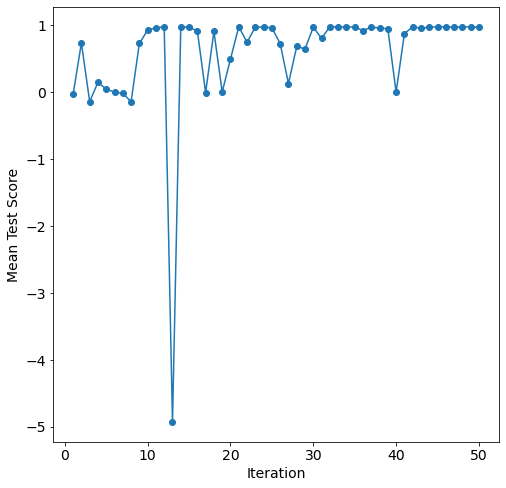

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(models="nn")

## Model Post-processing

With the models tuned and the top `num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. Additionally if you wish to update some hyper-parmeters, a dictionary similar to model initialization can be passed.

In [14]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 153 out of 153 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Epoch 1/200
75/75 [==============================] - 1s 5ms/step - loss: 0.2964 - mean_absolute_error: 0.2964 - val_loss: 0.1784 - val_mean_absolute_error: 0.1784
Epoch 2/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1831 - mean_absolute_error: 0.1831 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 3/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1692 - mean_absolute_error: 0.1692 - val_loss: 0.1476 - val_mean_absolute_error: 0.1476
Epoch 4/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1420 - mean_absolute_error: 0.1420 - val_loss: 0.1059 - val_mean_absolute_error: 0.1059
Epoch 5/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1114 - mean_absolute_error: 0.1114 - val_loss: 0.0892 - val_mean_absolute_error: 0.0892
Epoch 6/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1039 - mean_absolute_error: 0.1039 - val_loss: 0.0889 - val_mean_absolute_error: 0.0889
Epoch 7/200
75/75 [===

75/75 [==============================] - 0s 4ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 52/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0397 - mean_absolute_error: 0.0397 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188
Epoch 53/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0200 - val_mean_absolute_error: 0.0200
Epoch 54/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0403 - mean_absolute_error: 0.0403 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 55/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184
Epoch 56/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 57/200
75/75 [=========

75/75 [==============================] - 0s 3ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 102/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0178 - val_mean_absolute_error: 0.0178
Epoch 103/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0338 - mean_absolute_error: 0.0338 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194
Epoch 104/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0196 - val_mean_absolute_error: 0.0196
Epoch 105/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191
Epoch 106/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0345 - mean_absolute_error: 0.0345 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 107/200
75/75 [===

Epoch 151/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0193 - val_mean_absolute_error: 0.0193
Epoch 152/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0178 - val_mean_absolute_error: 0.0178
Epoch 153/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0312 - mean_absolute_error: 0.0312 - val_loss: 0.0178 - val_mean_absolute_error: 0.0178
Epoch 154/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0203 - val_mean_absolute_error: 0.0203
Epoch 155/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0201 - val_mean_absolute_error: 0.0201
Epoch 156/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 157/

38/38 [==============================] - 0s 2ms/step
Epoch 1/200
75/75 [==============================] - 1s 5ms/step - loss: 0.3225 - mean_absolute_error: 0.3225 - val_loss: 0.1790 - val_mean_absolute_error: 0.1790
Epoch 2/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1847 - mean_absolute_error: 0.1847 - val_loss: 0.1722 - val_mean_absolute_error: 0.1722
Epoch 3/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1779 - mean_absolute_error: 0.1779 - val_loss: 0.1660 - val_mean_absolute_error: 0.1660
Epoch 4/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1677 - mean_absolute_error: 0.1677 - val_loss: 0.1536 - val_mean_absolute_error: 0.1536
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1492 - mean_absolute_error: 0.1492 - val_loss: 0.1296 - val_mean_absolute_error: 0.1296
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1366 - mean_absolute_error: 0.1366 - val_loss: 0.1209 - v

75/75 [==============================] - 0s 4ms/step - loss: 0.0399 - mean_absolute_error: 0.0399 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177
Epoch 51/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0396 - mean_absolute_error: 0.0396 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191
Epoch 52/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0150 - val_mean_absolute_error: 0.0150
Epoch 53/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168
Epoch 54/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168
Epoch 55/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 56/200
75/75 [=========

75/75 [==============================] - 0s 4ms/step - loss: 0.0351 - mean_absolute_error: 0.0351 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169
Epoch 101/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172
Epoch 102/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177
Epoch 103/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0198 - val_mean_absolute_error: 0.0198
Epoch 104/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0190 - val_mean_absolute_error: 0.0190
Epoch 105/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.0174 - val_mean_absolute_error: 0.0174
Epoch 106/200
75/75 [===

Epoch 150/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175
Epoch 151/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0323 - mean_absolute_error: 0.0323 - val_loss: 0.0200 - val_mean_absolute_error: 0.0200
Epoch 152/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0185 - val_mean_absolute_error: 0.0185
Epoch 153/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0322 - mean_absolute_error: 0.0322 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177
Epoch 154/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0326 - mean_absolute_error: 0.0326 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 155/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169
Epoch 156/

Epoch 200/200
38/38 [==============================] - 0s 2ms/step
Epoch 1/200
75/75 [==============================] - 1s 5ms/step - loss: 0.3140 - mean_absolute_error: 0.3140 - val_loss: 0.1767 - val_mean_absolute_error: 0.1767
Epoch 2/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1820 - mean_absolute_error: 0.1820 - val_loss: 0.1705 - val_mean_absolute_error: 0.1705
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1749 - mean_absolute_error: 0.1749 - val_loss: 0.1605 - val_mean_absolute_error: 0.1605
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1619 - mean_absolute_error: 0.1619 - val_loss: 0.1431 - val_mean_absolute_error: 0.1431
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1435 - mean_absolute_error: 0.1435 - val_loss: 0.1231 - val_mean_absolute_error: 0.1231
Epoch 6/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1264 - mean_absolute_error: 0.1264 - val_lo

75/75 [==============================] - 0s 4ms/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192
Epoch 50/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 51/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0426 - mean_absolute_error: 0.0426 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 52/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0425 - mean_absolute_error: 0.0425 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 53/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0417 - mean_absolute_error: 0.0417 - val_loss: 0.0167 - val_mean_absolute_error: 0.0167
Epoch 54/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0419 - mean_absolute_error: 0.0419 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 55/200
75/75 [=========

75/75 [==============================] - 0s 4ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188
Epoch 100/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222
Epoch 101/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 102/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180
Epoch 103/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 104/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 105/200
75/75 [===

Epoch 149/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0187 - val_mean_absolute_error: 0.0187
Epoch 150/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 151/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184
Epoch 152/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 153/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0182 - val_mean_absolute_error: 0.0182
Epoch 154/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0184 - val_mean_absolute_error: 0.0184
Epoch 155/

Epoch 199/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 200/200
38/38 [==============================] - 0s 2ms/step
Epoch 1/200
75/75 [==============================] - 1s 5ms/step - loss: 0.2932 - mean_absolute_error: 0.2932 - val_loss: 0.1790 - val_mean_absolute_error: 0.1790
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1795 - mean_absolute_error: 0.1795 - val_loss: 0.1677 - val_mean_absolute_error: 0.1677
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1704 - mean_absolute_error: 0.1704 - val_loss: 0.1534 - val_mean_absolute_error: 0.1534
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1471 - mean_absolute_error: 0.1471 - val_loss: 0.1263 - val_mean_absolute_error: 0.1263
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1226 - mean_absolute_error: 0.1226 - val_

75/75 [==============================] - 0s 3ms/step - loss: 0.0418 - mean_absolute_error: 0.0418 - val_loss: 0.0216 - val_mean_absolute_error: 0.0216
Epoch 49/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0428 - mean_absolute_error: 0.0428 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 50/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 51/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0420 - mean_absolute_error: 0.0420 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 52/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0426 - mean_absolute_error: 0.0426 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225
Epoch 53/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0407 - mean_absolute_error: 0.0407 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 54/200
75/75 [=========

75/75 [==============================] - 0s 3ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0194 - val_mean_absolute_error: 0.0194
Epoch 99/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0200 - val_mean_absolute_error: 0.0200
Epoch 100/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 101/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231
Epoch 102/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - val_loss: 0.0217 - val_mean_absolute_error: 0.0217
Epoch 103/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0372 - mean_absolute_error: 0.0372 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226
Epoch 104/200
75/75 [====

Epoch 148/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 149/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 150/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0199 - val_mean_absolute_error: 0.0199
Epoch 151/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0348 - mean_absolute_error: 0.0348 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 152/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 153/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0201 - val_mean_absolute_error: 0.0201
Epoch 154/

Epoch 198/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0340 - mean_absolute_error: 0.0340 - val_loss: 0.0270 - val_mean_absolute_error: 0.0270
Epoch 199/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0331 - mean_absolute_error: 0.0331 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 200/200
38/38 [==============================] - 0s 2ms/step
Epoch 1/200
75/75 [==============================] - 1s 5ms/step - loss: 0.2863 - mean_absolute_error: 0.2863 - val_loss: 0.1766 - val_mean_absolute_error: 0.1766
Epoch 2/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1814 - mean_absolute_error: 0.1814 - val_loss: 0.1715 - val_mean_absolute_error: 0.1715
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 0.1714 - mean_absolute_error: 0.1714 - val_loss: 0.1552 - val_mean_absolute_error: 0.1552
Epoch 4/200
75/75 [==============================] - 0s 4ms/step - loss: 0.1397 - mean_absolute_error: 0.1397 - va

75/75 [==============================] - 0s 4ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170
Epoch 48/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0394 - mean_absolute_error: 0.0394 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 49/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0168 - val_mean_absolute_error: 0.0168
Epoch 50/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172
Epoch 51/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.0162 - val_mean_absolute_error: 0.0162
Epoch 52/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166
Epoch 53/200
75/75 [=========

75/75 [==============================] - 0s 4ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170
Epoch 98/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 99/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0172 - val_mean_absolute_error: 0.0172
Epoch 100/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170
Epoch 101/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175
Epoch 102/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0197 - val_mean_absolute_error: 0.0197
Epoch 103/200
75/75 [=====

Epoch 147/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0180 - val_mean_absolute_error: 0.0180
Epoch 148/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0195 - val_mean_absolute_error: 0.0195
Epoch 149/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192
Epoch 150/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0315 - mean_absolute_error: 0.0315 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191
Epoch 151/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0170 - val_mean_absolute_error: 0.0170
Epoch 152/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0318 - mean_absolute_error: 0.0318 - val_loss: 0.0192 - val_mean_absolute_error: 0.0192
Epoch 153/

Epoch 197/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0177 - val_mean_absolute_error: 0.0177
Epoch 198/200
75/75 [==============================] - 0s 4ms/step - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 199/200
75/75 [==============================] - 0s 3ms/step - loss: 0.0297 - mean_absolute_error: 0.0297 - val_loss: 0.0202 - val_mean_absolute_error: 0.0202
Epoch 200/200
38/38 [==============================] - 0s 2ms/step


The models can now be output using the `metrics` function in the `PostProcessor`. This returns an ordered table with training and testing $R^2$, mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE). By default these models are ordered by descending test $R^2$; however, it can also be ordered along other metrics using the `sort_by` parameter of `metrics`. For all but the $R^2$ the data presented is ascending.  

In [15]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.994997,0.010167,0.000202,0.014204,0.970271,0.029508,0.001329,0.036452
1,lasso,{'alpha': 0.0001963246637710169},0.994929,0.010426,0.000204,0.014300,0.969588,0.029903,0.001362,0.036901
2,lasso,{'alpha': 0.00028110058733608596},0.994858,0.010581,0.000207,0.014401,0.969255,0.030088,0.001378,0.037117
3,lasso,{'alpha': 0.000282024373848625},0.994857,0.010583,0.000207,0.014402,0.969251,0.030090,0.001378,0.037119
4,lasso,{'alpha': 0.0005489961520454027},0.994467,0.011233,0.000223,0.014943,0.968049,0.030731,0.001435,0.037880
5,lasso,{'alpha': 0.0007341191266862055},0.994050,0.011806,0.000240,0.015501,0.967081,0.031222,0.001481,0.038478
22,nn,"{'batch_size': 8, 'learning_rate': 0.000537899...",0.989075,0.016716,0.000452,0.021249,0.966613,0.031058,0.001529,0.039098
25,nn,"{'batch_size': 8, 'learning_rate': 0.000832892...",0.989430,0.016584,0.000439,0.020957,0.962629,0.033262,0.001680,0.040991
23,nn,"{'batch_size': 8, 'learning_rate': 0.000847798...",0.983886,0.020727,0.000670,0.025892,0.959793,0.033954,0.001803,0.042466
21,nn,"{'batch_size': 8, 'learning_rate': 0.000841551...",0.987356,0.018063,0.000537,0.023179,0.955499,0.035626,0.002035,0.045112


Using the `get_params` function we can see the parameters (only those subject to tuning) of a model by the name or index in the `metrics` table. For names given the configuration of that model with the best test $R^2$ is returned. If no index or name is given then the model with the best test $R^2$ is given. Here are the tuning configurations of the top model of each model type.

In [16]:
for model in model_settings["models"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs   normalize  positive
0      linear    True           True   None  deprecated     False 

  Model Types     alpha
0       lasso  0.000196 

  Model Types  max_depth  max_features  min_samples_leaf  min_samples_split
0       dtree          8             6                 4                  3 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn         20            5  2  distance 

  Model Types      criterion  max_features  min_samples_leaf  \
0     rforest  squared_error             4                 1   

   min_samples_split  n_estimators  
0                  5           108   

  Model Types  batch_size  learning_rate  num_layers  start_num_nodes
0          nn           8       0.000538           3              200 



To visualize the performance of these models the `diagonal_validation_plot` and `validation_plot` functions can be used to produce diagonal validation and validation plots. Diagonal validation plots show how well the outputs predicted by the model for the training and testing data sets compare to the actual output. A well fit model follows $y=x$.

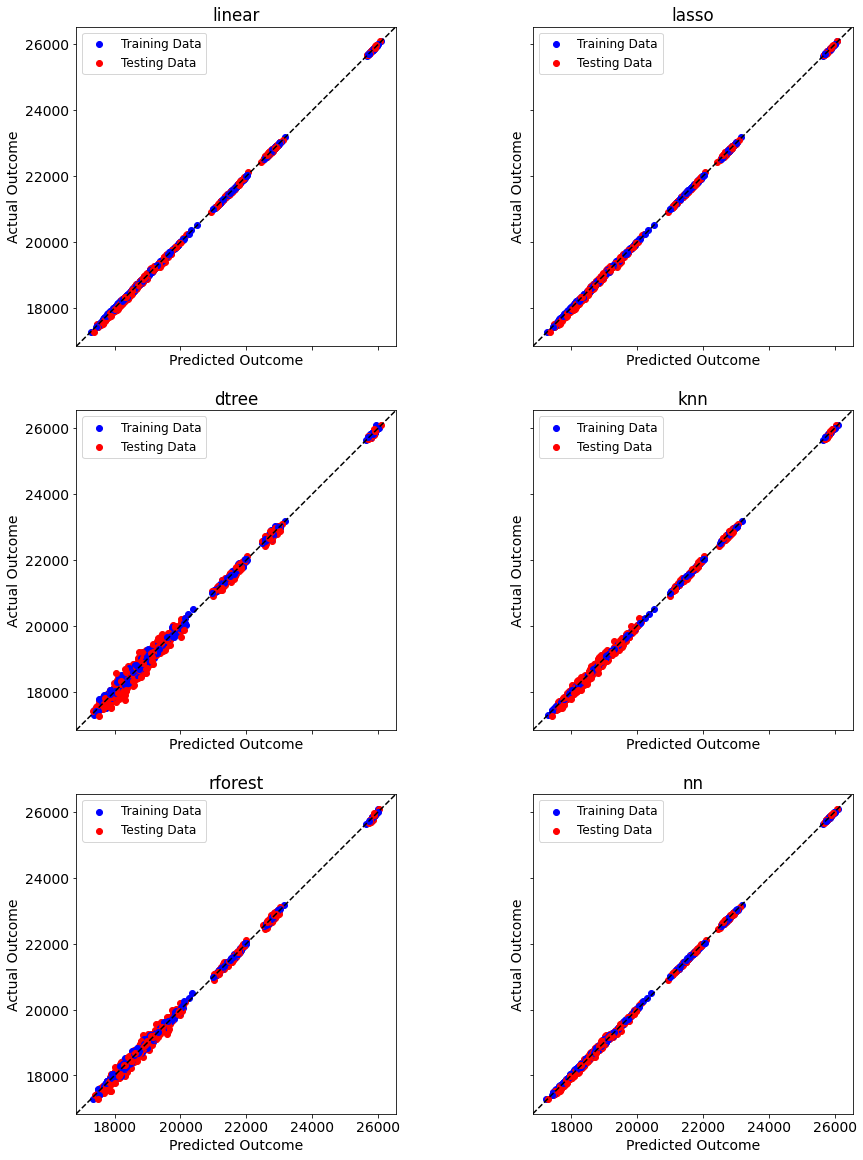

In [17]:
models = np.array([["linear", "lasso"], ["dtree", "knn"], ["rforest", "nn"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j], yscaler=preprocessor.yscaler)
        axarr[i, j].set_title(models[i, j])

Validation plots show the absolute error of the predicted output relative to the actual outputs of the testing data set. The function can evaluate all output or show just what is given in a list. This list can include column positions in the data set or the output names. For the diagonal validation plot below only the A-2, B-8, and C-8 fuel elements are shown.

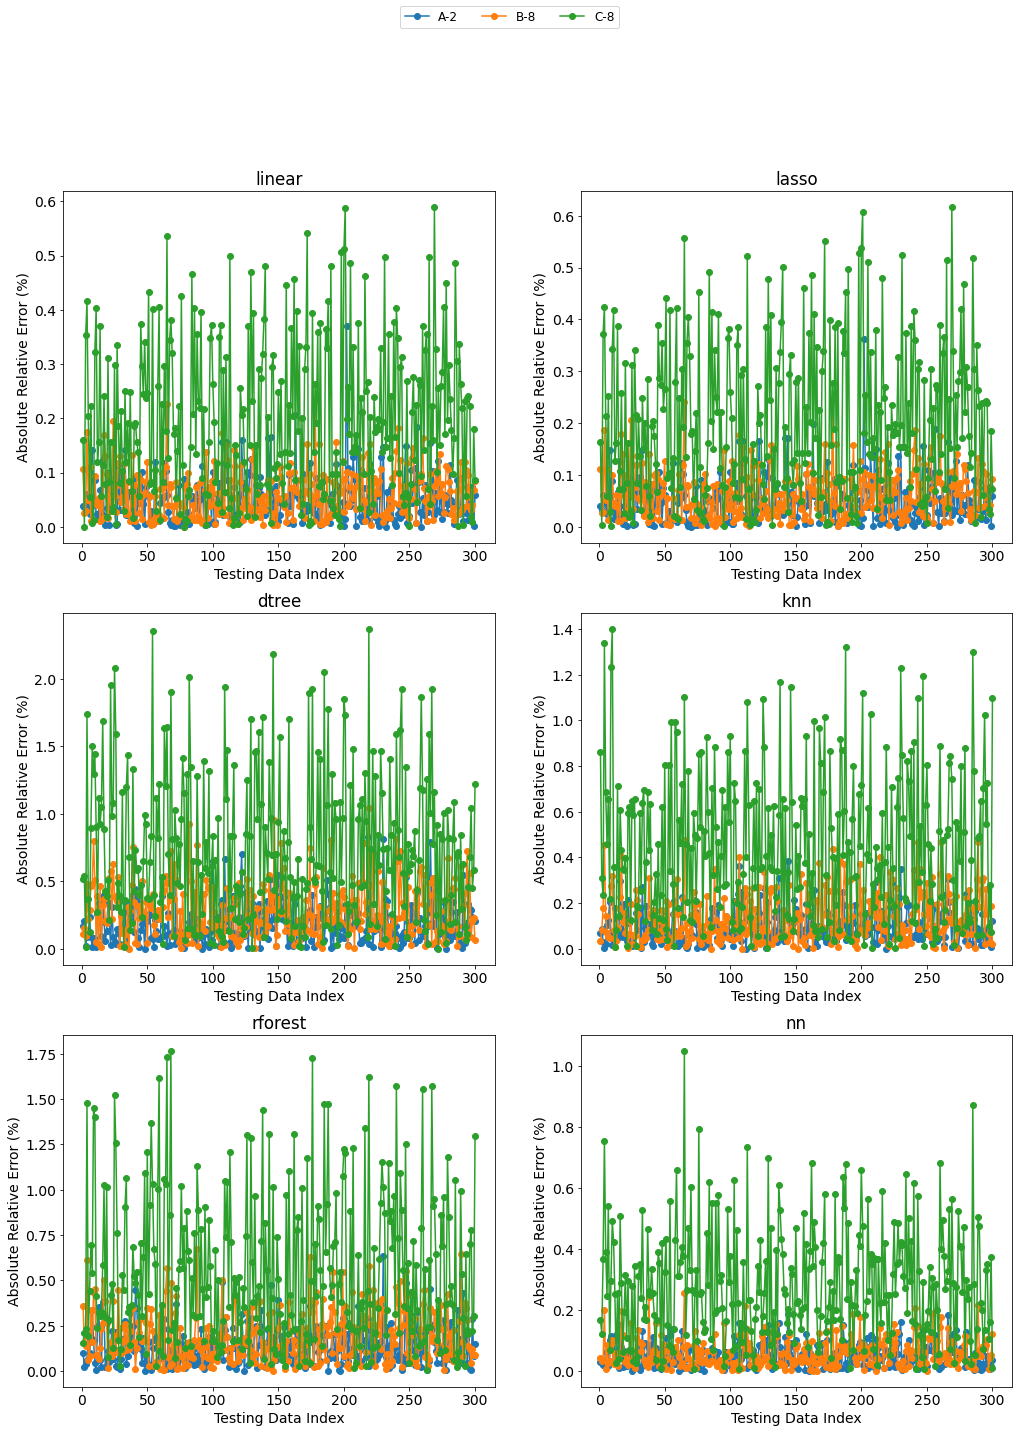

In [18]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["A-2", "B-8", "C-8"]
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y, yscaler=preprocessor.yscaler)
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(y, loc="upper center", ncol=4)

The diagonal validation and validation plots agree with the performance metrics. The errors of random forests or decision trees is higher than linear, lasso, neural networks, and k-nearest neighbors.

To further understand the behavior of the top neural network configurations we can plot the learning curve. Here the top neural network learning curve is shown but, similar to the `diagonal_validation_plot` and `validation_plot` functions, `nn_learning_plot` shows the neural network based on the index in `metrics` or, if no index is provided, the one with the best test $R^2$.

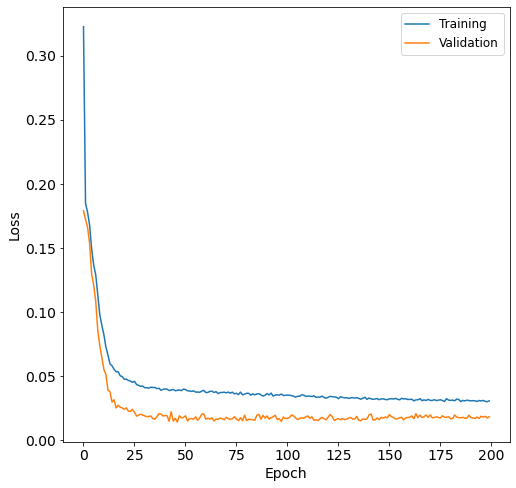

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

The validation curve is below the training for the each epoch; therefore, the top neural networks configuration is not overfit.

Finally, using the linear regression model we can generate a predicted power for each fuel element given the control blade heights.

/home/myerspat/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


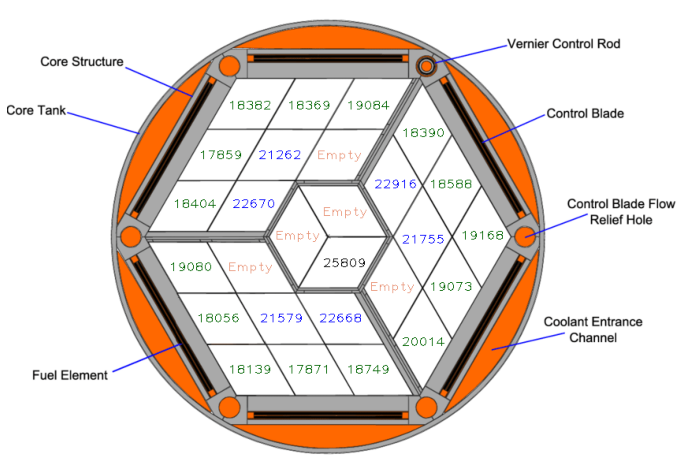

In [20]:
def plot_mitr(model, x, yscaler=None):
    pos=[(400,330), (465,230), (500,300), (395,400), (320,400), (285,255), (318,193),
         (500,165), (535,230), (575,295), (535,360), (500,430), (430,465), (355,465), 
         (280,465), (240,400), (205,335), (210,255), (243,193), (280,130), (355,130), 
         (430,130), (393,193), (460,360), (280,335), (400,265), (340,295)]
    
    Ynn=model.predict(np.array([x,]))
    if yscaler:
        Ynn=yscaler.inverse_transform(Ynn)
    Ynn=Ynn.flatten().tolist()
    
    image = cv2.imread("./supporting/mitr.png")
    for i in range(len(pos)):
        if i==0:
            image=cv2.putText(img=np.copy(image), text=str(int(Ynn[i])), org=pos[i], fontFace=1, fontScale=1.1, color=(0,0,0))
        if i in [1,2,3,4,5,6]:
            image=cv2.putText(img=np.copy(image), text=str(int(Ynn[i])), org=pos[i], fontFace=1, fontScale=1.1, color=(0,0,255)) 
        if i in list(range(7,22)):
            image=cv2.putText(img=np.copy(image), text=str(int(Ynn[i])), org=pos[i], fontFace=1, fontScale=1.1, color=(0, 100, 0)) 
        if i in list(range(22,28)):
            image=cv2.putText(img=np.copy(image), text=str('Empty'), org=pos[i], fontFace=1, fontScale=1.1, color=(233, 150, 122))            
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis('off')

x=[0.75266553, 0.90280633, 0.00539489, 0.25308624, 0.57678792, 0.77792903]

plot_mitr(postprocessor.get_model(model_type="linear"), x, preprocessor.yscaler)

## References

1. M. I. RADAIDEH, K. DU, P. SEURIN, D. SEYLER, X. GU, H. WANG, and K. SHIRVAN, “NEORL: NeuroEvolution Optimization with Reinforcement Learning,” CoRR, abs/2112.07057 (2021).
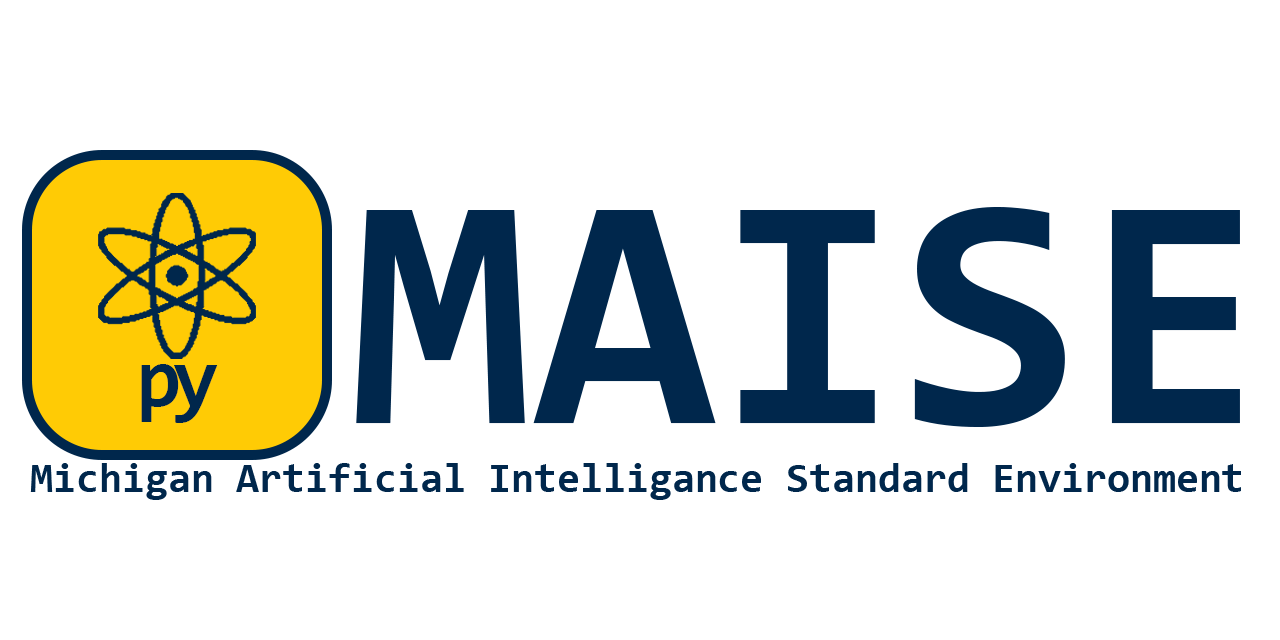